#**PGExplainer- Review-Datensatz**

In dieser Arbeitsmappe wird das Tuning und Training des PGExplainers durchgeführt.

Paper: Luo, Dongsheng u. a. (2020): Parameterized explainer for graph neural network. In: Advances
in neural information processing systems 33, 19620–19631.

Docu: https://diveintographs.readthedocs.io/en/latest/xgraph/method.html#dig.xgraph.method.PGExplainer

## Funktionsweise

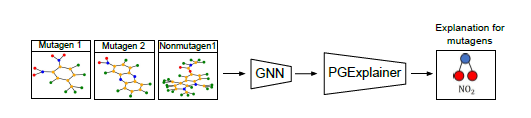

1. GNN trainieren auf einem Datensatz
2. Trainiertes GNN als Input für PGExplainer

Besonderheiten des PGExplainer:
- Globales Verständnis der von einem GNN gemachten Vorhersagen
- allgemeiner Erklärer (auf verschiedene GNN Anwendbar)
- Nutzt generatives probablistisches Modell zur Erstellung von Erklärungen -> Aufgdecken von zugrundeliegenden Strukturen, welche in Form von Kantenverteilugnen dargestellt werden
- Generierungsprozess wird mit einem deep NN parametrisiert, um verallgemeinerung zu erreichen (-> gelernten Parameter werden von allen Instanzen gleich verwendet)

Input
Top-K

Top-K gibt die Anzahl der Edges an, welche als wichtig zu bestimmen sind. In Kombination mit der durch den Explainer bestimmten Edge-Mask wird ein Grenzwert berechnet. Alle Edges, welche unter diesem liegen werden aussortiert. Hieraus kann eine Liste mit Knoten erstellt werden, welche besonders relevant für die Vorhersage des Models sind. Desto größer Top-K gewählt wird, desto mehr Knoten werden als relevant gewählt werden. Dies widerspricht der Anforderung an eine Erklärung möglichst wenige aber dafür hoch relevante Begründungen zu geben. Wird Top-K zu niedrig gewählt werden, kann es passieren das relevante Knoten aussortiert werden und die Erklärung sehr verkürzt oder unvollständig ist. Wichtige Faktoren für die Vorhersagen eines Models können dann nicht erkannt werden.

Output
Related Preds

Mask: Sicherheit der Vorhersage durch das GNN-Model bei Subgraph mit durch den Explainer als relevant markierten Knoten für die Ziel-Klasse (welche als am Wahrscheinlichsten durch das Model bei Input des gesamten Graphs ermittelt wurde)

Maskout: Sicherheit der Vorhersage durch das GNN-Model bei Subgraph mit durch den Explainer als irrelevant markierten Knoten (welche als am Wahrscheinlichsten durch das Model bei Input des gesamten Graphs ermittelt wurde)

Sparsity: Spärlichkeit der Lösung. 1 Keine Knoten wurden gewählt, 0 Alle Knoten wurden gewählt

Evalutaitonsmetrike:
Fidelity+ (Fidelity)

Hohe Werte bedeuten, dass durch Entfernen der unwichtigen Knoten nicht viel an der Vorhersagewahrscheinlichkeit des Modells geändert wurde. Aus diesem Grund lassen hier hohe Werte auf eine gute Erklärung des Explainers zurücksschließen.

Fidelity- (Fidelity_inv)

Niedrige Werte Bedeuten dass durch Entfernen der wichtigen Knoten die Vorhersagewahrscheinlichkeiten stark beeinflusst wurden. Hier sind daher niedrige Werte Ausdruck für eine gute Erklärung.
 

In [ ]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2

In [ ]:
%%capture
#!pip install dive-into-graphs

In [ ]:
%%capture
!git clone https://github.com/divelab/DIG.git
%cd DIG
!pip install .

In [ ]:
%%capture
!pip install pm4py

In [ ]:
# Hauptordner-Pfad
import torch
from pathlib import Path
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
%cd "/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM" 

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import joblib
# Module für das Preprocessing der verwendeten Datensätze
from preprocessing.loanApplication import *
from preprocessing.reviewSynthetic import *
from utilities_preprocessing import  GraphDatasetHelper

from models.gcn3_neu import *


from dig.xgraph.method import PGExplainer
from torch_geometric.data.batch import Batch
from dig.xgraph.evaluation import XCollector
from utilities_pgexplainer_tuning import run_tuning, save_hyperparam_results, split_dataset_2_8, visual_tuning_results
from train_gcn import load_gcn_key, load_gcn

In [ ]:
# Verwendete Laufzeit-Umgebung definieren (GPU oder CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##Datensatz laden

##Variablen

Hier sind alle Variablen zusammengefasst. Vor Ausführen der Datei können hier Konfigurationen vorgenommen werden

In [ ]:

# ---------------------------Trainingsdatensatz ------------------------
test_len = 100

# ---------------------------Variablen Model---------------------------
hidden_channel = 100

# ---------------------------Variablen XAI Methoden---------------------------
num_classes =  2  # Anzahl der Klassen: 0: Review wurde angenommen, 1: Review wurde abgelehnt

# PGExpaleiner
path_pgexplainer =  path / "xai_methods/pgexplainer/trainiert" # Speicherort für Parameter des PGExplainer
# pgexplainer_training_name = "pgexplainer_" + dataset_name  # Name der Parameter Datei


#fast_test = ds_test[:test_len]

## PGE Explainer 

Eine Implementierung in PyTorch Geometrics existiert im Package: Dive into Graphs (DIG)

Es wurde auf den bereits implementierten Explainer zurückgegriffen. Zur Visualisierung konnten die im Package bereitgestellten Methoden nicht verwendet werden. Diese wurde neu in Anlehnung an Haiyang Yu implementiert.



DIG: Dive into Graphs is developed by DIVE@TAMU. Contributors are Meng Liu*, Youzhi Luo*, Limei Wang*, Yaochen Xie*, Hao Yuan*, Shurui Gui*, Haiyang Yu*, Zhao Xu, Jingtun Zhang, Yi Liu, Keqiang Yan, Haoran Liu, Cong Fu, Bora Oztekin, Xuan Zhang, and Shuiwang Ji.

##Parameter Tuning

### Aktivitäten-basiert
-> review_sn_f3_ohe_2

#### Review - Aktivität

In [ ]:

# Laden eines Vorverarbeiteten Datensatzes
dataset_name = "review_sn_f3_ohe_2" 
dataset = torch.load(path / str("datasets/dataset_" + dataset_name))
feature  = joblib.load("datasets/encoder_" + dataset_name + ".joblib") 
input_dim = dataset[0].x.shape[1]
# Model laden
path_model = path / "models/"
model_name = "model_" + dataset_name

ds_train, ds_test = split_dataset_2_8(dataset)

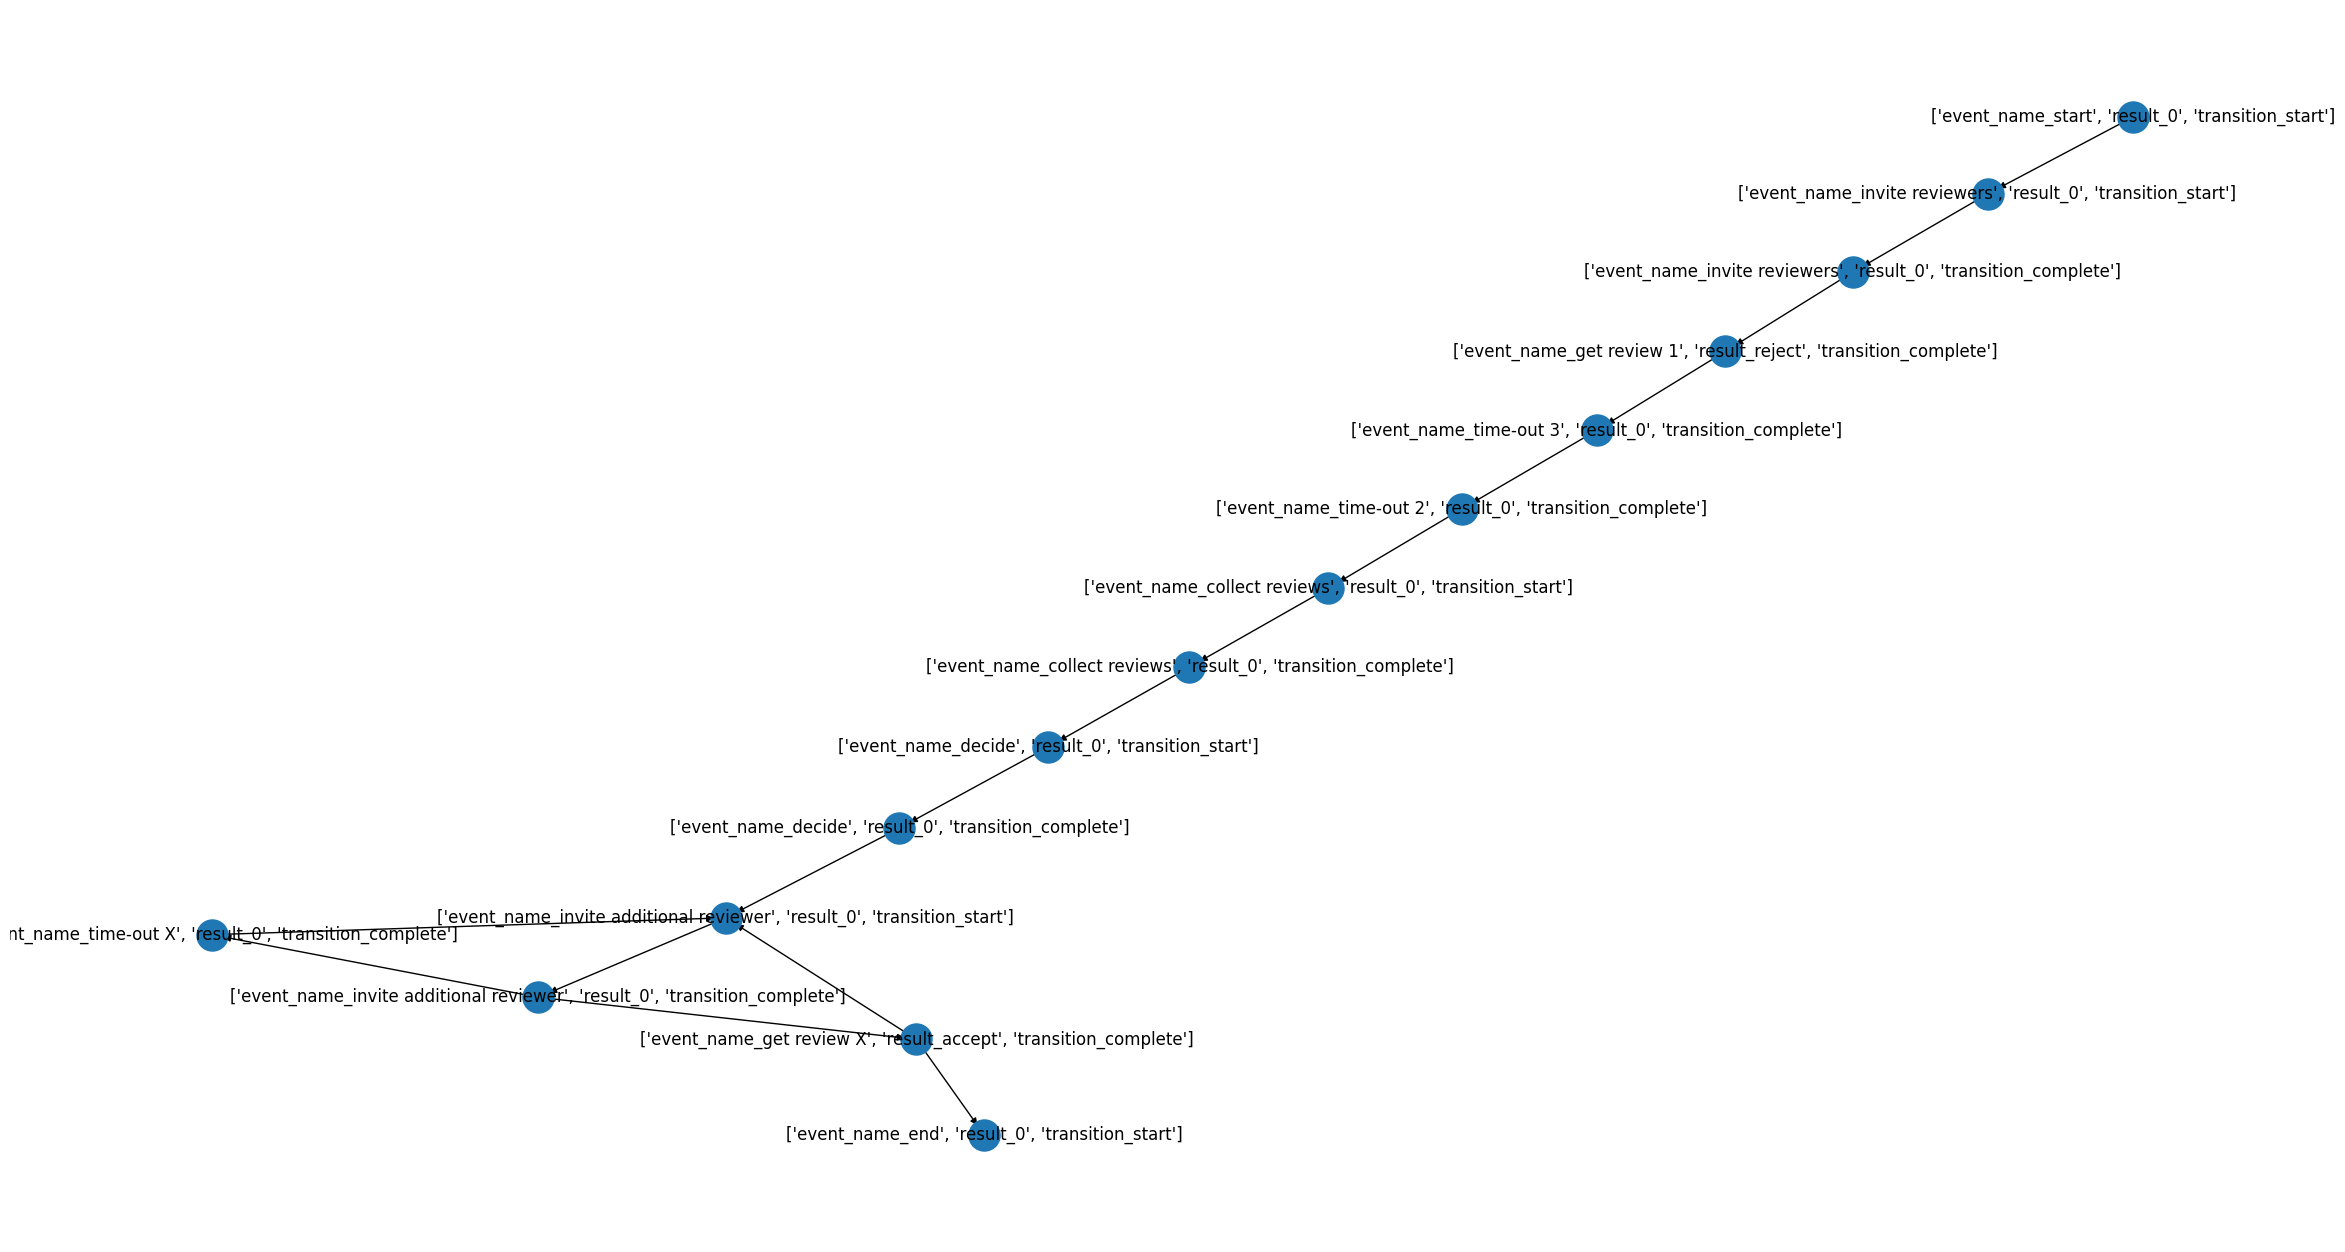

In [ ]:
from utilities_preprocessing import  GraphDatasetHelper
# # Namen können nur bei label encoder angezeigt werden
# Darstellung einer Graph-Instanz vom Review-ab Datensatz
data = ds_train[3]
helper = GraphDatasetHelper(node_feature = feature)
helper.visualise_dataset(data)

In [ ]:
dataset_name 

'review_sn_f3_ohe_2'

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 10
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:54<00:00, 146.02it/s]


Epoch: 0 | Loss: 8618.683827012777


100%|██████████| 8000/8000 [00:54<00:00, 147.89it/s]


Epoch: 1 | Loss: 3520.9320887625217


100%|██████████| 8000/8000 [00:54<00:00, 146.77it/s]


Epoch: 2 | Loss: 1330.4560585198924


100%|██████████| 8000/8000 [00:57<00:00, 138.11it/s]


Epoch: 3 | Loss: 1001.9498420436867


100%|██████████| 8000/8000 [00:53<00:00, 148.64it/s]


Epoch: 4 | Loss: 919.6207430828363


100%|██████████| 8000/8000 [00:57<00:00, 139.34it/s]


Epoch: 5 | Loss: 906.261589660251


100%|██████████| 8000/8000 [00:53<00:00, 148.84it/s]


Epoch: 6 | Loss: 902.3626616929541


100%|██████████| 8000/8000 [00:54<00:00, 147.75it/s]


Epoch: 7 | Loss: 891.3536473108106


100%|██████████| 8000/8000 [00:55<00:00, 144.39it/s]


Epoch: 8 | Loss: 879.6080415949109


100%|██████████| 8000/8000 [00:57<00:00, 139.48it/s]


Epoch: 9 | Loss: 861.927271535329
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649947807_0.05 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 68.32it/s]


Fidelity+: 0.4624983072280884, Fidelity-: 0.13362212479114532, Sparsity: 0.6113917827606201
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 10
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:1000], ds_test, dataset_name, device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 1000/1000 [00:06<00:00, 152.59it/s]


Epoch: 0 | Loss: 1072.4888908043504


100%|██████████| 1000/1000 [00:06<00:00, 153.23it/s]


Epoch: 1 | Loss: 620.8398298192769


100%|██████████| 1000/1000 [00:06<00:00, 154.11it/s]


Epoch: 2 | Loss: 196.40271471440792


100%|██████████| 1000/1000 [00:06<00:00, 152.58it/s]


Epoch: 3 | Loss: 144.109590748325


100%|██████████| 1000/1000 [00:06<00:00, 151.03it/s]


Epoch: 4 | Loss: 119.94964675651863


100%|██████████| 1000/1000 [00:06<00:00, 150.68it/s]


Epoch: 5 | Loss: 111.1934701766586


100%|██████████| 1000/1000 [00:06<00:00, 153.33it/s]


Epoch: 6 | Loss: 110.05264037003508


100%|██████████| 1000/1000 [00:06<00:00, 150.31it/s]


Epoch: 7 | Loss: 111.70965872693341


100%|██████████| 1000/1000 [00:06<00:00, 153.97it/s]


Epoch: 8 | Loss: 110.00588731706375


100%|██████████| 1000/1000 [00:06<00:00, 153.48it/s]


Epoch: 9 | Loss: 110.59158902731724
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:28<00:00, 70.10it/s]


Fidelity+: 0.44337084889411926, Fidelity-: 0.1532418429851532, Sparsity: 0.5940660238265991
save Hyperparameter


In [ ]:
param = {
    "lr": 0.001,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.001--------------------------


100%|██████████| 8000/8000 [00:52<00:00, 151.96it/s]


Epoch: 0 | Loss: 8853.419302720577


100%|██████████| 8000/8000 [00:52<00:00, 152.37it/s]


Epoch: 1 | Loss: 8660.12776644528


100%|██████████| 8000/8000 [00:52<00:00, 152.46it/s]


Epoch: 2 | Loss: 8569.334436677396


100%|██████████| 8000/8000 [00:52<00:00, 152.57it/s]


Epoch: 3 | Loss: 8271.053241666406


100%|██████████| 8000/8000 [00:52<00:00, 153.07it/s]


Epoch: 4 | Loss: 7730.989148778841
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649936171_0.001 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 67.33it/s]


Fidelity+: 0.14587029814720154, Fidelity-: 0.33470869064331055, Sparsity: 0.8494217991828918
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 8000/8000 [00:52<00:00, 153.65it/s]


Epoch: 0 | Loss: 8619.301728803664


100%|██████████| 8000/8000 [00:52<00:00, 153.03it/s]


Epoch: 1 | Loss: 7846.230055760592


100%|██████████| 8000/8000 [00:52<00:00, 153.35it/s]


Epoch: 2 | Loss: 6632.794337619096


100%|██████████| 8000/8000 [00:52<00:00, 153.38it/s]


Epoch: 3 | Loss: 4673.324475990608


100%|██████████| 8000/8000 [00:51<00:00, 154.34it/s]


Epoch: 4 | Loss: 2966.474183520302
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649936828_0.005 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 68.40it/s]


Fidelity+: 0.4087025225162506, Fidelity-: 0.054699528962373734, Sparsity: 0.7793262004852295
save Hyperparameter


In [ ]:
param = {
    "lr": 0.0001,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.0001--------------------------


100%|██████████| 8000/8000 [00:52<00:00, 153.77it/s]


Epoch: 0 | Loss: 8821.376306690276


100%|██████████| 8000/8000 [00:52<00:00, 153.69it/s]


Epoch: 1 | Loss: 8875.474717583507


100%|██████████| 8000/8000 [00:51<00:00, 153.87it/s]


Epoch: 2 | Loss: 9073.699085917324


100%|██████████| 8000/8000 [00:52<00:00, 153.44it/s]


Epoch: 3 | Loss: 8982.285548299551


100%|██████████| 8000/8000 [00:52<00:00, 153.54it/s]


Epoch: 4 | Loss: 9293.49253963679
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649936501_0.0001 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 68.42it/s]


Fidelity+: 0.037106387317180634, Fidelity-: 0.4172665476799011, Sparsity: 0.8381194472312927
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.1, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:51<00:00, 154.57it/s]


Epoch: 0 | Loss: 17405.36767360568


100%|██████████| 8000/8000 [00:51<00:00, 155.77it/s]


Epoch: 1 | Loss: 9889.255984127522


100%|██████████| 8000/8000 [00:52<00:00, 153.48it/s]


Epoch: 2 | Loss: 3427.431178972125


100%|██████████| 8000/8000 [00:52<00:00, 153.35it/s]


Epoch: 3 | Loss: 1474.4102551834658


100%|██████████| 8000/8000 [00:52<00:00, 153.10it/s]


Epoch: 4 | Loss: 1312.4846213605488
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649937156_0.05 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 66.98it/s]


Fidelity+: 0.4682926535606384, Fidelity-: 0.1395956426858902, Sparsity: 0.5765268802642822
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:52<00:00, 153.34it/s]


Epoch: 0 | Loss: 7910.576212402433


100%|██████████| 8000/8000 [00:52<00:00, 153.56it/s]


Epoch: 1 | Loss: 3662.2834735726938


100%|██████████| 8000/8000 [00:52<00:00, 153.18it/s]


Epoch: 2 | Loss: 1049.7389478250407


100%|██████████| 8000/8000 [00:52<00:00, 152.95it/s]


Epoch: 3 | Loss: 949.1396800666116


100%|██████████| 8000/8000 [00:52<00:00, 152.19it/s]


Epoch: 4 | Loss: 826.6842086821562
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649937482_0.05 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 67.93it/s]


Fidelity+: 0.4591304063796997, Fidelity-: 0.19386987388134003, Sparsity: 0.6179239749908447
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:53<00:00, 150.26it/s]


Epoch: 0 | Loss: 8639.228622812778


100%|██████████| 8000/8000 [00:53<00:00, 150.87it/s]


Epoch: 1 | Loss: 2595.6449072808027


100%|██████████| 8000/8000 [00:52<00:00, 151.88it/s]


Epoch: 2 | Loss: 1080.9759173095226


100%|██████████| 8000/8000 [00:52<00:00, 152.28it/s]


Epoch: 3 | Loss: 932.7721531435382


100%|██████████| 8000/8000 [00:53<00:00, 150.92it/s]


Epoch: 4 | Loss: 939.7036334174918
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649945372_0.05 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 68.11it/s]


Fidelity+: 0.4688984155654907, Fidelity-: 0.13689610362052917, Sparsity: 0.5805450677871704
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.00005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:53<00:00, 148.31it/s]


Epoch: 0 | Loss: 8860.232039488852


100%|██████████| 8000/8000 [00:54<00:00, 147.94it/s]


Epoch: 1 | Loss: 3952.613641547039


100%|██████████| 8000/8000 [00:54<00:00, 147.93it/s]


Epoch: 2 | Loss: 1244.785056409426


100%|██████████| 8000/8000 [00:53<00:00, 148.16it/s]


Epoch: 3 | Loss: 936.0909003638662


100%|██████████| 8000/8000 [00:53<00:00, 149.66it/s]


Epoch: 4 | Loss: 876.6113778177532
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649945706_0.05 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 68.07it/s]


Fidelity+: 0.4657150208950043, Fidelity-: 0.14199092984199524, Sparsity: 0.5966241955757141
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 3.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:53<00:00, 148.86it/s]


Epoch: 0 | Loss: 9158.055927954614


100%|██████████| 8000/8000 [00:53<00:00, 149.46it/s]


Epoch: 1 | Loss: 4364.570834089071


100%|██████████| 8000/8000 [00:53<00:00, 149.44it/s]


Epoch: 2 | Loss: 1411.181694040075


100%|██████████| 8000/8000 [00:53<00:00, 148.18it/s]


Epoch: 3 | Loss: 1130.3105187010951


100%|██████████| 8000/8000 [00:53<00:00, 148.80it/s]


Epoch: 4 | Loss: 958.1635915208608
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649946043_0.05 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 68.55it/s]


Fidelity+: 0.4549836814403534, Fidelity-: 0.14057165384292603, Sparsity: 0.6052564382553101
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 10
}
model = load_gcn_key(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:54<00:00, 147.62it/s]


Epoch: 0 | Loss: 8706.32269867137


100%|██████████| 8000/8000 [00:54<00:00, 146.49it/s]


Epoch: 1 | Loss: 4445.0882261656225


100%|██████████| 8000/8000 [00:54<00:00, 146.32it/s]


Epoch: 2 | Loss: 1532.4167151842266


100%|██████████| 8000/8000 [00:54<00:00, 146.15it/s]


Epoch: 3 | Loss: 1073.1834458084777


100%|██████████| 8000/8000 [00:53<00:00, 148.65it/s]


Epoch: 4 | Loss: 924.2444911336061


100%|██████████| 8000/8000 [00:54<00:00, 146.98it/s]


Epoch: 5 | Loss: 873.2710444272961


100%|██████████| 8000/8000 [00:57<00:00, 138.68it/s]


Epoch: 6 | Loss: 865.0091193276457


100%|██████████| 8000/8000 [00:54<00:00, 147.47it/s]


Epoch: 7 | Loss: 862.8857883829041


100%|██████████| 8000/8000 [00:53<00:00, 149.15it/s]


Epoch: 8 | Loss: 856.9276492332574


100%|██████████| 8000/8000 [00:54<00:00, 146.62it/s]


Epoch: 9 | Loss: 853.0458527196897
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649948428_0.05 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 67.88it/s]


Fidelity+: 0.4564479887485504, Fidelity-: 0.16802453994750977, Sparsity: 0.6116929650306702
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 4.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:51<00:00, 153.90it/s]


Epoch: 0 | Loss: 8616.32287594676


100%|██████████| 8000/8000 [00:51<00:00, 154.01it/s]


Epoch: 1 | Loss: 4781.7370290495455


100%|██████████| 8000/8000 [00:52<00:00, 153.33it/s]


Epoch: 2 | Loss: 2092.903776081279


100%|██████████| 8000/8000 [00:52<00:00, 152.62it/s]


Epoch: 3 | Loss: 1125.961915676482


100%|██████████| 8000/8000 [00:52<00:00, 153.45it/s]


Epoch: 4 | Loss: 983.8172516296618
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649939118_0.05 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 67.77it/s]


Fidelity+: 0.4634585380554199, Fidelity-: 0.1324218213558197, Sparsity: 0.5969093441963196
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 8.0,
    "t1": 4.0,
    "epochs": 10
}
model = load_gcn_key(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:53<00:00, 148.70it/s]


Epoch: 0 | Loss: 8815.708315826952


100%|██████████| 8000/8000 [00:54<00:00, 146.19it/s]


Epoch: 1 | Loss: 6135.76396214962


100%|██████████| 8000/8000 [00:53<00:00, 149.61it/s]


Epoch: 2 | Loss: 2082.7978732027113


100%|██████████| 8000/8000 [00:54<00:00, 147.82it/s]


Epoch: 3 | Loss: 1399.8098911400884


100%|██████████| 8000/8000 [00:54<00:00, 147.24it/s]


Epoch: 4 | Loss: 1125.8655834728852


100%|██████████| 8000/8000 [00:54<00:00, 147.64it/s]


Epoch: 5 | Loss: 1000.1593945836648


100%|██████████| 8000/8000 [00:54<00:00, 147.69it/s]


Epoch: 6 | Loss: 933.0112110550981


100%|██████████| 8000/8000 [00:53<00:00, 148.15it/s]


Epoch: 7 | Loss: 897.4896167714614


100%|██████████| 8000/8000 [00:53<00:00, 149.98it/s]


Epoch: 8 | Loss: 881.1478405963862


100%|██████████| 8000/8000 [00:54<00:00, 147.24it/s]


Epoch: 9 | Loss: 874.6459161957027
Saved: /content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM/xai_methods/pgexplainer/tuning/review_sn_f3_ohe_2/1649949041_0.05 _review_sn_f3_ohe_2
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:29<00:00, 68.66it/s]


Fidelity+: 0.4638363718986511, Fidelity-: 0.1401766538619995, Sparsity: 0.5902016758918762
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
    "info": "test und train Daten gleich"
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], dataset_name , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 500/500 [00:03<00:00, 149.81it/s]


Epoch: 0 | Loss: 474.544091489166


100%|██████████| 500/500 [00:03<00:00, 147.82it/s]


Epoch: 1 | Loss: 195.1326240990311


100%|██████████| 500/500 [00:03<00:00, 149.91it/s]


Epoch: 2 | Loss: 78.03916718252003


100%|██████████| 500/500 [00:03<00:00, 152.09it/s]


Epoch: 3 | Loss: 63.565115849720314


100%|██████████| 500/500 [00:03<00:00, 150.85it/s]


Epoch: 4 | Loss: 62.485129419132136
PGExplainer Anwenden


100%|██████████| 500/500 [00:06<00:00, 71.49it/s]


Fidelity+: 0.43252110481262207, Fidelity-: 0.15851891040802002, Sparsity: 0.5949787497520447
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 152.74it/s]


Epoch: 0 | Loss: 5120.201318336651


100%|██████████| 5000/5000 [00:30<00:00, 165.52it/s]


Epoch: 1 | Loss: 1996.3992540501058


100%|██████████| 5000/5000 [00:29<00:00, 166.79it/s]


Epoch: 2 | Loss: 690.2305809492245


100%|██████████| 5000/5000 [00:30<00:00, 165.41it/s]


Epoch: 3 | Loss: 555.4308647299185


100%|██████████| 5000/5000 [00:30<00:00, 166.00it/s]


Epoch: 4 | Loss: 519.7198624974699
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:13<00:00, 71.60it/s]


Fidelity+: 0.42340773344039917, Fidelity-: 0.16169732809066772, Sparsity: 0.607491672039032
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn(dataset_name, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, dataset_name, device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:51<00:00, 156.62it/s]


Epoch: 0 | Loss: 8609.599505823106


100%|██████████| 8000/8000 [00:50<00:00, 157.28it/s]


Epoch: 1 | Loss: 3529.4383821431547


100%|██████████| 8000/8000 [00:50<00:00, 157.32it/s]


Epoch: 2 | Loss: 1221.5182259306312


100%|██████████| 8000/8000 [00:50<00:00, 157.04it/s]


Epoch: 3 | Loss: 928.9989283063915


100%|██████████| 8000/8000 [00:50<00:00, 157.94it/s]


Epoch: 4 | Loss: 855.2455924198148
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:28<00:00, 70.28it/s]


Fidelity+: 0.4456077218055725, Fidelity-: 0.1494493931531906, Sparsity: 0.5972588062286377
save Hyperparameter


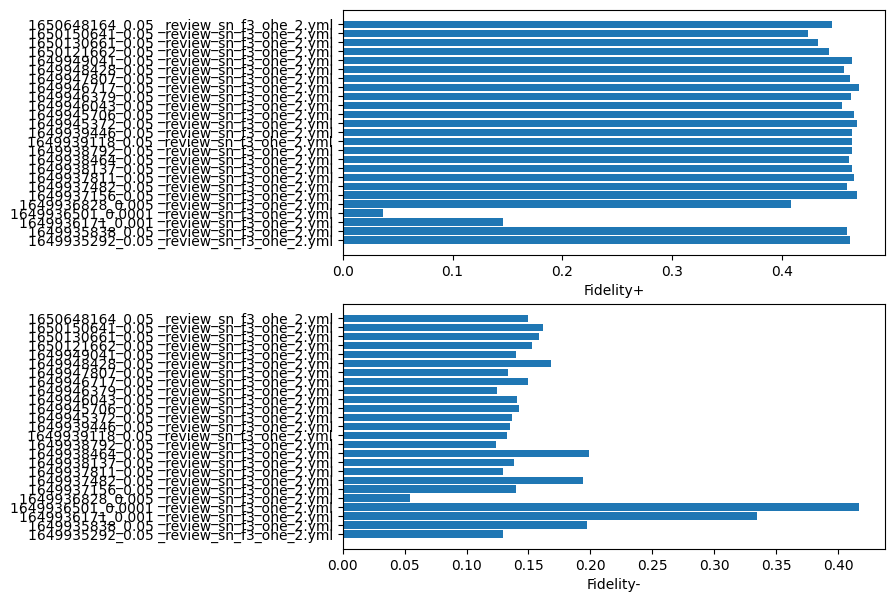

In [ ]:
visual_tuning_results(f"{dataset_name}", path)

### Event basiert
-> review_all_events_f5_ohe_2_prefix

#### Review- Event Datensatz

In [ ]:
# Laden eines Vorverarbeiteten Datensatzes
dataset_name = "review_all_events_f5_ohe_2_prefix" # "review_sn_f3_ohe_2"  loan_sn_f2_ohe_wEvents_4
dataset = torch.load(path / str("datasets/dataset_" + dataset_name))
feature  = joblib.load("datasets/encoder_" + dataset_name + ".joblib") 


In [ ]:
data = dataset[0][0]

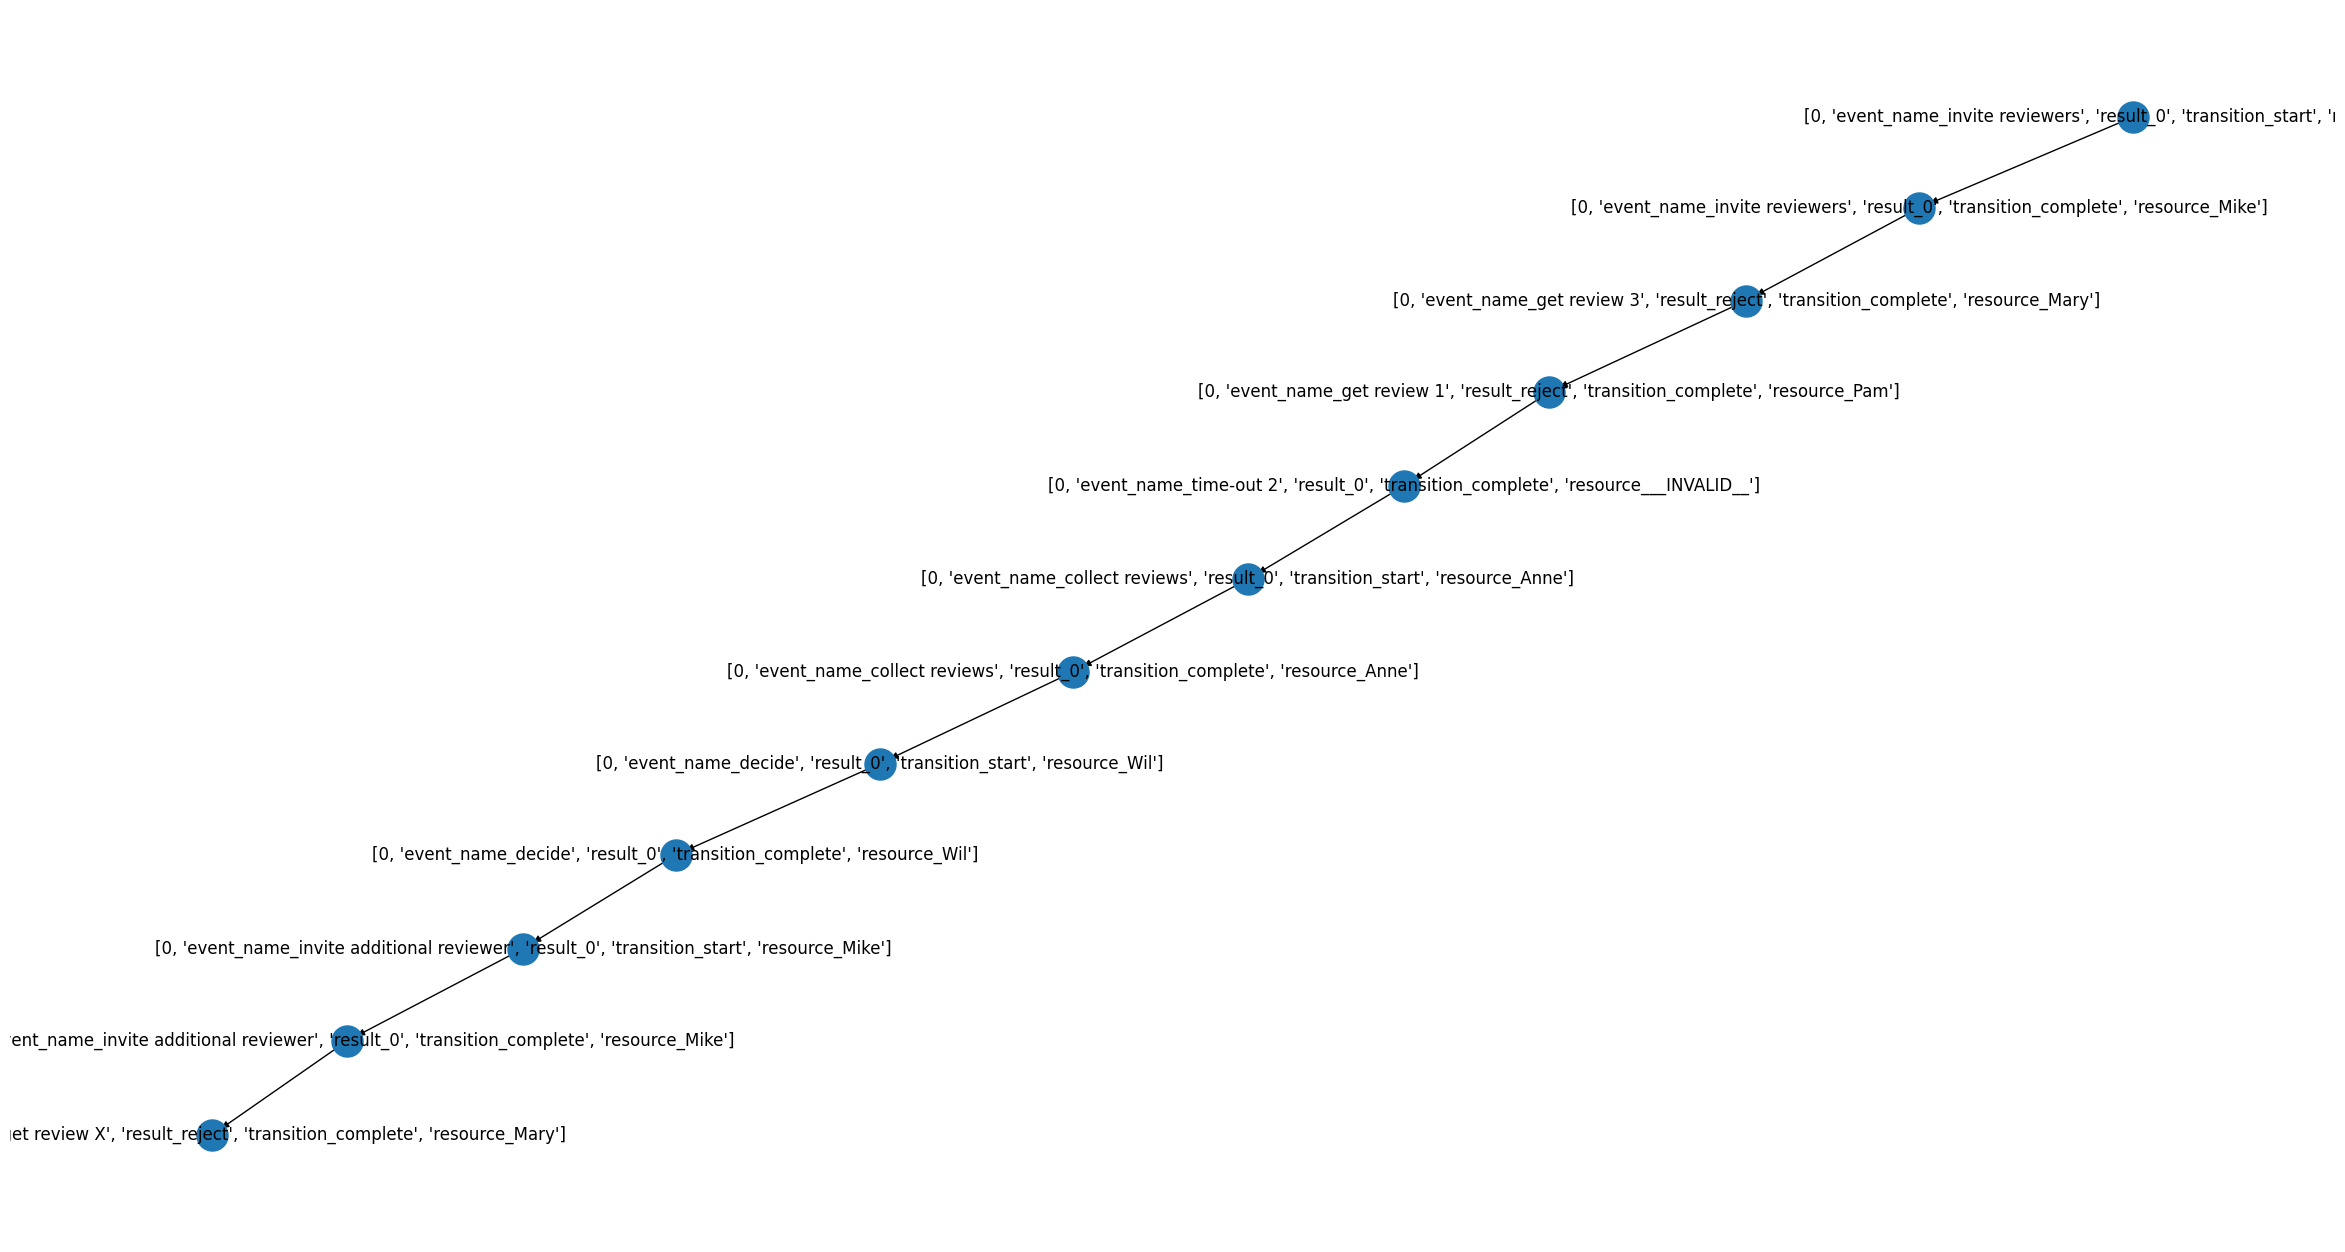

In [ ]:
helper = GraphDatasetHelper(data = data, node_feature = feature[0])
helper.visualise_event_based(1)

#### Ganzer Graph

In [ ]:
dataset_name

'review_all_events_f5_ohe_2_prefix'

In [ ]:
# Dataset und Model
key = 0
dataset0 = dataset[key]
input_dim = dataset0[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset0)

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [01:17<00:00, 103.19it/s]


Epoch: 0 | Loss: 1540.0451107695699


100%|██████████| 8000/8000 [01:17<00:00, 103.18it/s]


Epoch: 1 | Loss: 1538.0289778094739


100%|██████████| 8000/8000 [01:17<00:00, 102.72it/s]


Epoch: 2 | Loss: 1311.4140677209944


100%|██████████| 8000/8000 [01:17<00:00, 103.57it/s]


Epoch: 3 | Loss: 1217.832116595935


100%|██████████| 8000/8000 [01:17<00:00, 102.66it/s]


Epoch: 4 | Loss: 1105.1288697805721
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:44<00:00, 44.49it/s]


Fidelity+: 0.06763079017400742, Fidelity-: 0.46710050106048584, Sparsity: 0.9251534342765808
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_test[:100], ds_test[:100], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 100/100 [00:00<00:00, 104.11it/s]


Epoch: 0 | Loss: 16.718613151460886


100%|██████████| 100/100 [00:00<00:00, 100.98it/s]


Epoch: 1 | Loss: 14.912702737376094


100%|██████████| 100/100 [00:00<00:00, 100.27it/s]


Epoch: 2 | Loss: 13.720397841185331


100%|██████████| 100/100 [00:00<00:00, 101.29it/s]


Epoch: 3 | Loss: 16.044400949031115


100%|██████████| 100/100 [00:00<00:00, 101.52it/s]


Epoch: 4 | Loss: 13.816357657313347
PGExplainer Anwenden


100%|██████████| 100/100 [00:02<00:00, 44.05it/s]

Fidelity+: 0.00041502772364765406, Fidelity-: 0.46511393785476685, Sparsity: 0.9184863567352295
save Hyperparameter


In [ ]:
param = {
    "lr": 0.001,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.001--------------------------


100%|██████████| 8000/8000 [01:17<00:00, 102.59it/s]


Epoch: 0 | Loss: 1603.7666396461427


100%|██████████| 8000/8000 [01:18<00:00, 102.14it/s]


Epoch: 1 | Loss: 1573.5042205490172


100%|██████████| 8000/8000 [01:18<00:00, 102.32it/s]


Epoch: 2 | Loss: 1668.656501479447


100%|██████████| 8000/8000 [01:18<00:00, 102.23it/s]


Epoch: 3 | Loss: 1718.801429932937


100%|██████████| 8000/8000 [01:18<00:00, 102.30it/s]


Epoch: 4 | Loss: 1806.396304398775
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:44<00:00, 44.47it/s]


Fidelity+: 0.08493698388338089, Fidelity-: 0.38775283098220825, Sparsity: 0.6513675451278687
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.005--------------------------


100%|██████████| 8000/8000 [01:19<00:00, 100.94it/s]


Epoch: 0 | Loss: 1591.0680383481085


100%|██████████| 8000/8000 [01:19<00:00, 101.22it/s]


Epoch: 1 | Loss: 1518.1398412957788


100%|██████████| 8000/8000 [01:18<00:00, 102.53it/s]


Epoch: 2 | Loss: 1490.7389752678573


100%|██████████| 8000/8000 [01:18<00:00, 102.56it/s]


Epoch: 3 | Loss: 1491.0684972330928


100%|██████████| 8000/8000 [01:18<00:00, 102.03it/s]


Epoch: 4 | Loss: 1420.9666087031364
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:44<00:00, 45.25it/s]


Fidelity+: 0.028629189357161522, Fidelity-: 0.46926066279411316, Sparsity: 0.751581072807312
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 10
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [01:16<00:00, 104.80it/s]


Epoch: 0 | Loss: 1547.9226436428726


100%|██████████| 8000/8000 [01:16<00:00, 104.49it/s]


Epoch: 1 | Loss: 1438.5743970964104


100%|██████████| 8000/8000 [01:16<00:00, 104.76it/s]


Epoch: 2 | Loss: 1260.1314416565


100%|██████████| 8000/8000 [01:17<00:00, 103.84it/s]


Epoch: 3 | Loss: 1221.8897719159722


100%|██████████| 8000/8000 [01:16<00:00, 104.00it/s]


Epoch: 4 | Loss: 1159.3388160513714


100%|██████████| 8000/8000 [01:16<00:00, 104.64it/s]


Epoch: 5 | Loss: 1485.7383803678676


100%|██████████| 8000/8000 [01:16<00:00, 104.61it/s]


Epoch: 6 | Loss: 1117.229760574177


100%|██████████| 8000/8000 [01:17<00:00, 103.23it/s]


Epoch: 7 | Loss: 1070.970592471771


100%|██████████| 8000/8000 [01:17<00:00, 102.73it/s]


Epoch: 8 | Loss: 957.5387978234794


100%|██████████| 8000/8000 [01:17<00:00, 102.77it/s]


Epoch: 9 | Loss: 879.1150505658006
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:44<00:00, 45.44it/s]


Fidelity+: 0.021157406270503998, Fidelity-: 0.5159080624580383, Sparsity: 0.925676703453064
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:30<00:00, 162.56it/s]


Epoch: 0 | Loss: 713.4442985858768


100%|██████████| 5000/5000 [00:30<00:00, 162.56it/s]


Epoch: 1 | Loss: 871.6758602513


100%|██████████| 5000/5000 [00:30<00:00, 162.10it/s]


Epoch: 2 | Loss: 994.6226707501337


100%|██████████| 5000/5000 [00:30<00:00, 163.04it/s]


Epoch: 3 | Loss: 626.3524930193089


100%|██████████| 5000/5000 [00:30<00:00, 162.81it/s]


Epoch: 4 | Loss: 610.4242977839895
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:13<00:00, 71.87it/s]


Fidelity+: 0.06830829381942749, Fidelity-: 0.4678440988063812, Sparsity: 0.8751935362815857
save Hyperparameter


Da keine guten Ergebnisse gefunden werden konnten wurde getestet, wie gut die Erklärungen sind, wenn der Explainer lediglich auf Instanzen angewendet wird, welche er bereits gesehen hat, wodurch der Generalisierungsfehler vermieden wird

- Die Ergebnisse sind hier jedoch noch schlechter, wofür keine Erklärung gefunden werden konnte

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 500/500 [00:04<00:00, 101.94it/s]


Epoch: 0 | Loss: 87.51952014863491


100%|██████████| 500/500 [00:04<00:00, 100.79it/s]


Epoch: 1 | Loss: 95.8110419549048


100%|██████████| 500/500 [00:04<00:00, 101.06it/s]


Epoch: 2 | Loss: 74.93015242367983


100%|██████████| 500/500 [00:04<00:00, 100.62it/s]


Epoch: 3 | Loss: 68.653799043037


100%|██████████| 500/500 [00:05<00:00, 99.86it/s] 


Epoch: 4 | Loss: 64.2958595873788
PGExplainer Anwenden


100%|██████████| 500/500 [00:11<00:00, 43.89it/s]


Fidelity+: 2.9730976166320033e-05, Fidelity-: 0.5025303959846497, Sparsity: 0.9605883955955505
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.005--------------------------


100%|██████████| 500/500 [00:05<00:00, 98.70it/s]


Epoch: 0 | Loss: 87.68113914877176


100%|██████████| 500/500 [00:05<00:00, 89.67it/s] 


Epoch: 1 | Loss: 89.68581647053361


100%|██████████| 500/500 [00:05<00:00, 98.75it/s] 


Epoch: 2 | Loss: 86.74052135273814


100%|██████████| 500/500 [00:05<00:00, 99.28it/s] 


Epoch: 3 | Loss: 92.27536062337458


100%|██████████| 500/500 [00:04<00:00, 100.04it/s]


Epoch: 4 | Loss: 98.46828925050795
PGExplainer Anwenden


100%|██████████| 500/500 [00:11<00:00, 43.35it/s]


Fidelity+: 0.026619769632816315, Fidelity-: 0.46008190512657166, Sparsity: 0.8121187090873718
save Hyperparameter


In [ ]:
param = {
    "lr": 0.0005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:500], ds_train[:500], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.0005--------------------------


100%|██████████| 500/500 [00:05<00:00, 97.90it/s]


Epoch: 0 | Loss: 85.56578754633665


100%|██████████| 500/500 [00:05<00:00, 98.64it/s]


Epoch: 1 | Loss: 94.16527604684234


100%|██████████| 500/500 [00:05<00:00, 98.10it/s]


Epoch: 2 | Loss: 89.97550884820521


100%|██████████| 500/500 [00:05<00:00, 98.37it/s]


Epoch: 3 | Loss: 87.76148495078087


100%|██████████| 500/500 [00:05<00:00, 97.91it/s]


Epoch: 4 | Loss: 99.06222948618233
PGExplainer Anwenden


100%|██████████| 500/500 [00:11<00:00, 43.51it/s]


Fidelity+: 0.01898822747170925, Fidelity-: 0.42253997921943665, Sparsity: 0.8223333954811096
save Hyperparameter


Mit Train- und Test-Split

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:31<00:00, 160.96it/s]


Epoch: 0 | Loss: 699.592873333022


100%|██████████| 5000/5000 [00:31<00:00, 160.12it/s]


Epoch: 1 | Loss: 546.1898660603911


100%|██████████| 5000/5000 [00:31<00:00, 160.57it/s]


Epoch: 2 | Loss: 524.8570698648691


100%|██████████| 5000/5000 [00:31<00:00, 160.41it/s]


Epoch: 3 | Loss: 509.6769020445645


100%|██████████| 5000/5000 [00:31<00:00, 160.53it/s]


Epoch: 4 | Loss: 474.1133249141276
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 70.11it/s]


Fidelity+: 0.1357545256614685, Fidelity-: 0.29217657446861267, Sparsity: 0.6169146299362183
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.0001, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5,
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:31<00:00, 159.97it/s]


Epoch: 0 | Loss: 437.9916871715686


100%|██████████| 5000/5000 [00:31<00:00, 160.85it/s]


Epoch: 1 | Loss: 200.89276920934208


100%|██████████| 5000/5000 [00:31<00:00, 159.63it/s]


Epoch: 2 | Loss: 146.57710649253568


100%|██████████| 5000/5000 [00:30<00:00, 161.49it/s]


Epoch: 3 | Loss: 146.55854486237513


100%|██████████| 5000/5000 [00:31<00:00, 159.18it/s]


Epoch: 4 | Loss: 151.73197707359213
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 70.62it/s]


Fidelity+: 0.01977870985865593, Fidelity-: 0.4739431142807007, Sparsity: 0.9676719903945923
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 1,
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:31<00:00, 160.43it/s]


Epoch: 0 | Loss: 685.9489110801369
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 70.09it/s]


Fidelity+: 0.12639683485031128, Fidelity-: 0.3061291575431824, Sparsity: 0.6118937134742737
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 1
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 154.61it/s]


Epoch: 0 | Loss: 934.5021902769804
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:16<00:00, 60.27it/s]


Fidelity+: 0.13047157227993011, Fidelity-: 0.32014673948287964, Sparsity: 0.6074497699737549
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train[:5000], ds_test[:1000], f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5000/5000 [00:32<00:00, 152.15it/s]


Epoch: 0 | Loss: 948.6520540565252


100%|██████████| 5000/5000 [00:32<00:00, 153.26it/s]


Epoch: 1 | Loss: 855.0615081489086


100%|██████████| 5000/5000 [00:32<00:00, 152.79it/s]


Epoch: 2 | Loss: 785.8615637645125


100%|██████████| 5000/5000 [00:32<00:00, 153.25it/s]


Epoch: 3 | Loss: 710.4000993091613


100%|██████████| 5000/5000 [00:32<00:00, 152.92it/s]


Epoch: 4 | Loss: 580.4928713776171
PGExplainer Anwenden


100%|██████████| 1000/1000 [00:14<00:00, 67.04it/s]


Fidelity+: 0.13249827921390533, Fidelity-: 0.3279748558998108, Sparsity: 0.575620174407959
save Hyperparameter


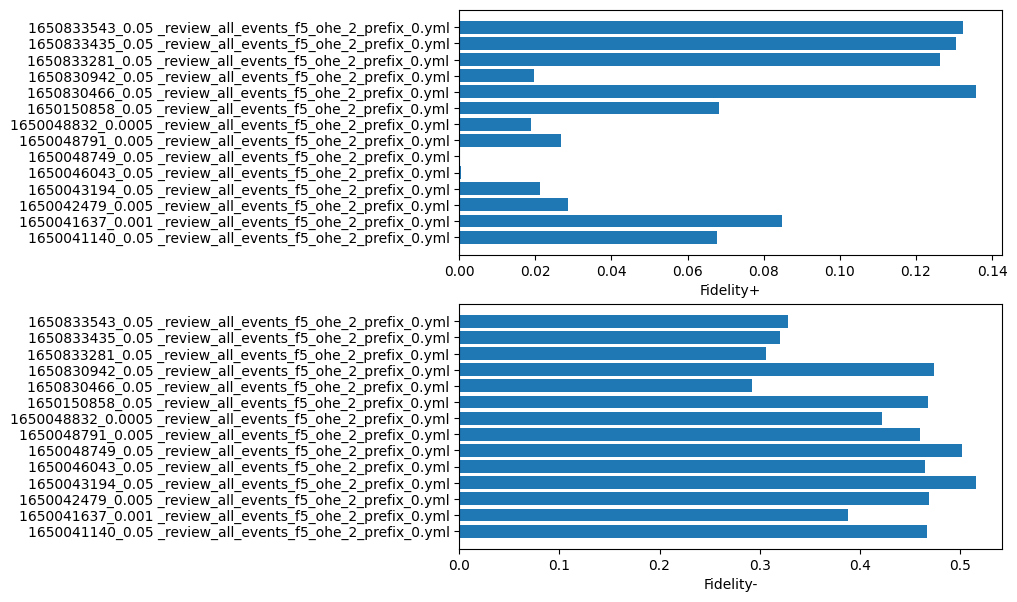

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

####Länge 4

In [ ]:
dataset_name

'review_all_events_f5_ohe_2_prefix'

In [ ]:
# Dataset und Model
key = 4
dataset4 = dataset[key]
input_dim = dataset4[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset4)

In [ ]:
print(path)

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:49<00:00, 161.61it/s]


Epoch: 0 | Loss: 3467.057140432298


100%|██████████| 8000/8000 [00:49<00:00, 160.80it/s]


Epoch: 1 | Loss: 3463.0829981938004


100%|██████████| 8000/8000 [00:49<00:00, 161.87it/s]


Epoch: 2 | Loss: 3447.9494793452322


100%|██████████| 8000/8000 [00:49<00:00, 161.88it/s]


Epoch: 3 | Loss: 3414.4783663004637


100%|██████████| 8000/8000 [00:48<00:00, 163.41it/s]


Epoch: 4 | Loss: 3358.1898940056562
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:27<00:00, 72.63it/s]


Fidelity+: 0.18968255817890167, Fidelity-: -0.08562514930963516, Sparsity: 0.5
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 8000/8000 [00:49<00:00, 162.44it/s]


Epoch: 0 | Loss: 3472.773070514202


100%|██████████| 8000/8000 [00:49<00:00, 161.50it/s]


Epoch: 1 | Loss: 3482.9792729988694


100%|██████████| 8000/8000 [00:49<00:00, 162.93it/s]


Epoch: 2 | Loss: 3489.48186692968


100%|██████████| 8000/8000 [00:49<00:00, 161.85it/s]


Epoch: 3 | Loss: 3491.800513908267


100%|██████████| 8000/8000 [00:49<00:00, 161.60it/s]


Epoch: 4 | Loss: 3507.6795297302306
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:27<00:00, 72.21it/s]


Fidelity+: 0.1634404957294464, Fidelity-: -0.059383079409599304, Sparsity: 0.5
save Hyperparameter


In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.01--------------------------


100%|██████████| 8000/8000 [00:49<00:00, 162.21it/s]


Epoch: 0 | Loss: 3467.0835336223245


100%|██████████| 8000/8000 [00:49<00:00, 161.88it/s]


Epoch: 1 | Loss: 3475.91502995044


100%|██████████| 8000/8000 [00:49<00:00, 162.32it/s]


Epoch: 2 | Loss: 3478.9310548752546


100%|██████████| 8000/8000 [00:49<00:00, 162.11it/s]


Epoch: 3 | Loss: 3477.634775046259


100%|██████████| 8000/8000 [00:49<00:00, 163.24it/s]


Epoch: 4 | Loss: 3486.3624728396535
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:27<00:00, 71.52it/s]


Fidelity+: 0.1634404957294464, Fidelity-: -0.059383079409599304, Sparsity: 0.5
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:49<00:00, 162.16it/s]


Epoch: 0 | Loss: 3359.0295487754047


100%|██████████| 8000/8000 [00:49<00:00, 162.50it/s]


Epoch: 1 | Loss: 3343.1969480738044


100%|██████████| 8000/8000 [00:49<00:00, 161.12it/s]


Epoch: 2 | Loss: 3317.8656362444162


100%|██████████| 8000/8000 [00:49<00:00, 161.64it/s]


Epoch: 3 | Loss: 3294.553620349616


100%|██████████| 8000/8000 [00:49<00:00, 163.10it/s]


Epoch: 4 | Loss: 3296.160956092179
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:27<00:00, 72.93it/s]


Fidelity+: 0.1634404957294464, Fidelity-: -0.059383079409599304, Sparsity: 0.5
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:49<00:00, 162.44it/s]


Epoch: 0 | Loss: 3463.6053930968046


100%|██████████| 8000/8000 [00:49<00:00, 161.91it/s]


Epoch: 1 | Loss: 3466.415360696614


100%|██████████| 8000/8000 [00:49<00:00, 161.46it/s]


Epoch: 2 | Loss: 3441.365868818015


100%|██████████| 8000/8000 [00:49<00:00, 162.94it/s]


Epoch: 3 | Loss: 3412.5120108164847


100%|██████████| 8000/8000 [00:49<00:00, 161.27it/s]


Epoch: 4 | Loss: 3411.4540833495557
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:28<00:00, 71.40it/s]


Fidelity+: 0.17572417855262756, Fidelity-: -0.07166679203510284, Sparsity: 0.5
save Hyperparameter


In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.01--------------------------


100%|██████████| 8000/8000 [00:53<00:00, 150.93it/s]


Epoch: 0 | Loss: 3466.614049911499


100%|██████████| 8000/8000 [00:53<00:00, 150.38it/s]


Epoch: 1 | Loss: 3474.7694479227066


100%|██████████| 8000/8000 [00:53<00:00, 150.75it/s]


Epoch: 2 | Loss: 3479.9484557509422


100%|██████████| 8000/8000 [00:53<00:00, 149.48it/s]


Epoch: 3 | Loss: 3489.181419506669


100%|██████████| 8000/8000 [00:56<00:00, 141.58it/s]


Epoch: 4 | Loss: 3492.3039154857397
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:27<00:00, 71.86it/s]


Fidelity+: 0.1634404957294464, Fidelity-: -0.059383079409599304, Sparsity: 0.5
save Hyperparameter


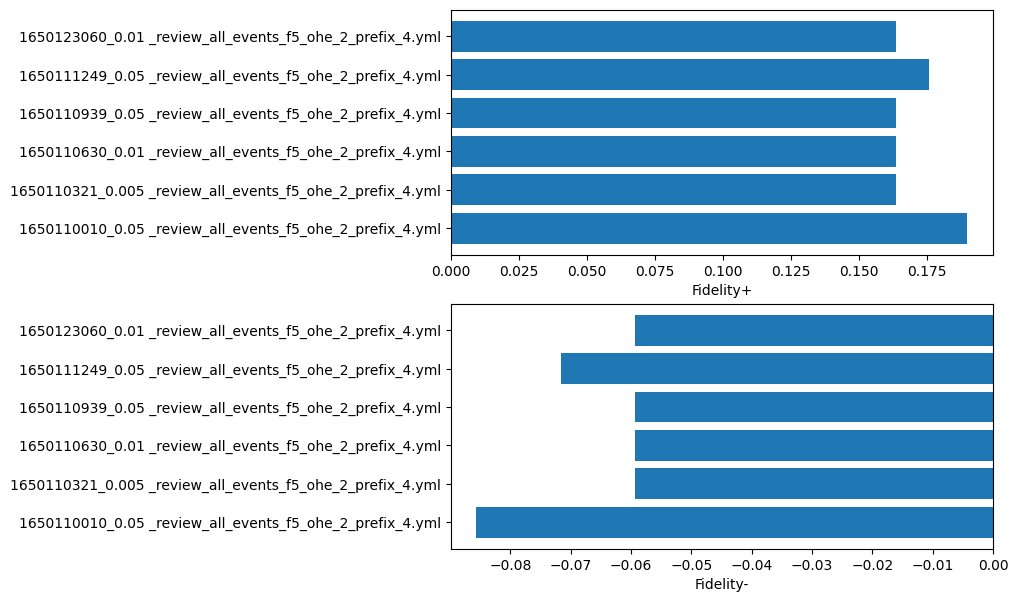

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

#### Länge 7

In [ ]:
# Dataset und Model
key = 7
dataset7 = dataset[key]
input_dim = dataset7[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset7)

In [ ]:
print(path)

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 8000/8000 [00:50<00:00, 159.59it/s]


Epoch: 0 | Loss: 4798.036136746407


100%|██████████| 8000/8000 [00:50<00:00, 157.99it/s]


Epoch: 1 | Loss: 4625.129870116711


100%|██████████| 8000/8000 [00:49<00:00, 162.05it/s]


Epoch: 2 | Loss: 4533.405350252986


100%|██████████| 8000/8000 [00:49<00:00, 160.95it/s]


Epoch: 3 | Loss: 4547.370358452201


100%|██████████| 8000/8000 [00:49<00:00, 160.85it/s]


Epoch: 4 | Loss: 4550.733415693045
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:27<00:00, 73.53it/s]


Fidelity+: 1.788139358804841e-10, Fidelity-: 0.19721387326717377, Sparsity: 1.0
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 8000/8000 [00:50<00:00, 158.13it/s]


Epoch: 0 | Loss: 4797.3636155724525


100%|██████████| 8000/8000 [00:53<00:00, 150.25it/s]


Epoch: 1 | Loss: 4783.8949020802975


100%|██████████| 8000/8000 [00:55<00:00, 144.98it/s]


Epoch: 2 | Loss: 4773.180722087622


100%|██████████| 8000/8000 [00:56<00:00, 141.26it/s]


Epoch: 3 | Loss: 4748.973382383585


100%|██████████| 8000/8000 [00:56<00:00, 141.21it/s]


Epoch: 4 | Loss: 4707.248350977898
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:30<00:00, 66.65it/s]


Fidelity+: 0.07431484013795853, Fidelity-: 0.08551385253667831, Sparsity: 0.5700715184211731
save Hyperparameter


In [ ]:
param = {
    "lr": 0.001,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.001--------------------------


100%|██████████| 8000/8000 [00:51<00:00, 155.31it/s]


Epoch: 0 | Loss: 4798.260260254145


100%|██████████| 8000/8000 [00:50<00:00, 159.54it/s]


Epoch: 1 | Loss: 4794.080209881067


100%|██████████| 8000/8000 [00:50<00:00, 156.94it/s]


Epoch: 2 | Loss: 4792.842250600457


100%|██████████| 8000/8000 [00:59<00:00, 135.58it/s]


Epoch: 3 | Loss: 4786.141676217318


100%|██████████| 8000/8000 [01:04<00:00, 124.01it/s]


Epoch: 4 | Loss: 4788.878934785724
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:33<00:00, 59.81it/s]


Fidelity+: 0.06810907274484634, Fidelity-: 0.09166526049375534, Sparsity: 0.5697857737541199
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 8000/8000 [00:50<00:00, 159.88it/s]


Epoch: 0 | Loss: 4582.380197137594


100%|██████████| 8000/8000 [00:49<00:00, 161.60it/s]


Epoch: 1 | Loss: 4563.139654070139


100%|██████████| 8000/8000 [00:49<00:00, 160.43it/s]


Epoch: 2 | Loss: 4528.174977838993


100%|██████████| 8000/8000 [00:54<00:00, 147.05it/s]


Epoch: 3 | Loss: 4473.584072038531


100%|██████████| 8000/8000 [01:04<00:00, 124.18it/s]


Epoch: 4 | Loss: 4402.279965341091
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:33<00:00, 58.82it/s]


Fidelity+: 0.06485213339328766, Fidelity-: 0.09435155987739563, Sparsity: 0.571428656578064
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 8000/8000 [00:52<00:00, 153.15it/s]


Epoch: 0 | Loss: 4794.106060475111


100%|██████████| 8000/8000 [00:49<00:00, 162.41it/s]


Epoch: 1 | Loss: 4784.745866447687


100%|██████████| 8000/8000 [00:49<00:00, 161.99it/s]


Epoch: 2 | Loss: 4767.417369261384


100%|██████████| 8000/8000 [00:50<00:00, 158.44it/s]


Epoch: 3 | Loss: 4738.173323377967


100%|██████████| 8000/8000 [00:49<00:00, 161.96it/s]


Epoch: 4 | Loss: 4699.867280870676
PGExplainer Anwenden


100%|██████████| 2000/2000 [00:27<00:00, 71.67it/s]


Fidelity+: 0.06843239068984985, Fidelity-: 0.09034664928913116, Sparsity: 0.5704286098480225
save Hyperparameter


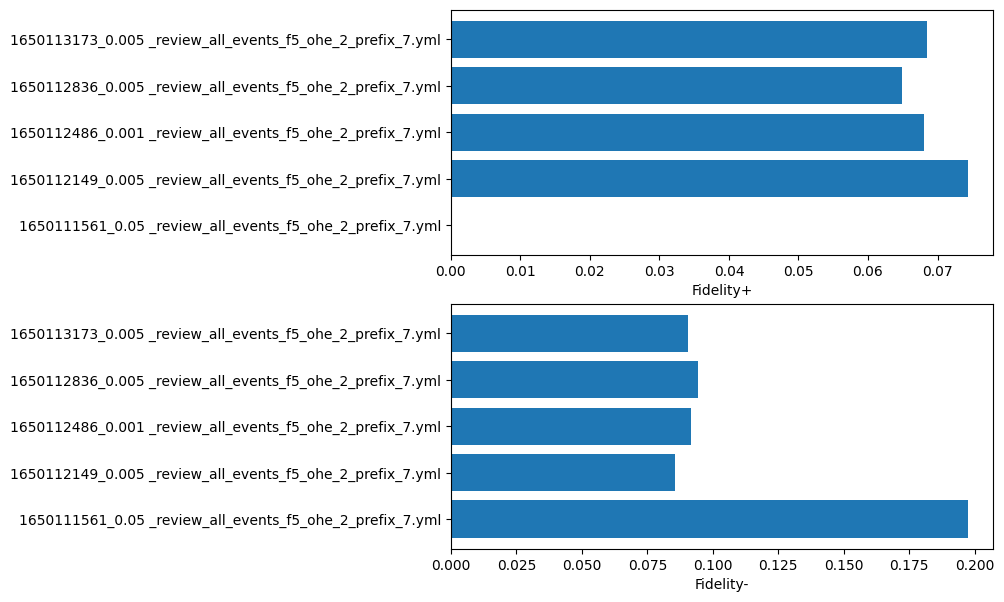

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

#### Länge 10

In [ ]:
# Dataset und Model
key = 10
dataset10 = dataset[key]
input_dim = dataset10[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset10)

In [ ]:
print(path)

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 7495/7495 [00:47<00:00, 156.29it/s]


Epoch: 0 | Loss: 4880.134116441011


100%|██████████| 7495/7495 [00:47<00:00, 156.78it/s]


Epoch: 1 | Loss: 4792.528504878283


100%|██████████| 7495/7495 [00:50<00:00, 149.31it/s]


Epoch: 2 | Loss: 4744.624435603619


100%|██████████| 7495/7495 [00:49<00:00, 150.21it/s]


Epoch: 3 | Loss: 4762.802191913128


100%|██████████| 7495/7495 [00:47<00:00, 156.43it/s]


Epoch: 4 | Loss: 4769.295490592718
PGExplainer Anwenden


100%|██████████| 1874/1874 [00:25<00:00, 72.79it/s]


Fidelity+: 0.16211587190628052, Fidelity-: 0.015982860699295998, Sparsity: 0.5069370269775391
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 7495/7495 [00:47<00:00, 158.02it/s]


Epoch: 0 | Loss: 4876.374198138714


100%|██████████| 7495/7495 [00:47<00:00, 157.96it/s]


Epoch: 1 | Loss: 4871.578059107065


100%|██████████| 7495/7495 [00:47<00:00, 157.57it/s]


Epoch: 2 | Loss: 4858.908208727837


100%|██████████| 7495/7495 [00:47<00:00, 158.17it/s]


Epoch: 3 | Loss: 4842.099271863699


100%|██████████| 7495/7495 [00:47<00:00, 158.13it/s]


Epoch: 4 | Loss: 4815.779107749462
PGExplainer Anwenden


100%|██████████| 1874/1874 [00:26<00:00, 70.94it/s]


Fidelity+: 0.16505709290504456, Fidelity-: 0.012826665304601192, Sparsity: 0.5
save Hyperparameter


In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.01--------------------------


100%|██████████| 7495/7495 [00:48<00:00, 154.73it/s]


Epoch: 0 | Loss: 4879.088152974844


100%|██████████| 7495/7495 [00:48<00:00, 154.90it/s]


Epoch: 1 | Loss: 4862.445350140333


100%|██████████| 7495/7495 [00:48<00:00, 154.47it/s]


Epoch: 2 | Loss: 4828.710923105478


100%|██████████| 7495/7495 [00:48<00:00, 154.67it/s]


Epoch: 3 | Loss: 4778.845463037491


100%|██████████| 7495/7495 [00:48<00:00, 155.08it/s]


Epoch: 4 | Loss: 4738.8116473555565
PGExplainer Anwenden


100%|██████████| 1874/1874 [00:25<00:00, 72.52it/s]


Fidelity+: 0.16591301560401917, Fidelity-: 0.011225482448935509, Sparsity: 0.5
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 7495/7495 [00:48<00:00, 153.63it/s]


Epoch: 0 | Loss: 4577.962146729231


100%|██████████| 7495/7495 [00:48<00:00, 153.61it/s]


Epoch: 1 | Loss: 4365.724586457014


100%|██████████| 7495/7495 [00:48<00:00, 153.54it/s]


Epoch: 2 | Loss: 4177.125394463539


100%|██████████| 7495/7495 [00:48<00:00, 153.12it/s]


Epoch: 3 | Loss: 4166.018767982721


100%|██████████| 7495/7495 [00:49<00:00, 150.43it/s]


Epoch: 4 | Loss: 4165.95639693737
PGExplainer Anwenden


100%|██████████| 1874/1874 [00:25<00:00, 72.56it/s]


Fidelity+: -1.2722442543910972e-10, Fidelity-: 0.16570883989334106, Sparsity: 1.0
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 7495/7495 [00:50<00:00, 149.44it/s]


Epoch: 0 | Loss: 4879.512748837471


100%|██████████| 7495/7495 [00:49<00:00, 150.93it/s]


Epoch: 1 | Loss: 4814.603701621294


100%|██████████| 7495/7495 [00:49<00:00, 152.55it/s]


Epoch: 2 | Loss: 4739.122714102268


100%|██████████| 7495/7495 [00:49<00:00, 152.35it/s]


Epoch: 3 | Loss: 4761.147823065519


100%|██████████| 7495/7495 [00:48<00:00, 153.91it/s]


Epoch: 4 | Loss: 4770.443176358938
PGExplainer Anwenden


100%|██████████| 1874/1874 [00:26<00:00, 69.94it/s]


Fidelity+: 0.1558341681957245, Fidelity-: 0.021044252440333366, Sparsity: 0.5239593982696533
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 3.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 7495/7495 [00:49<00:00, 151.66it/s]


Epoch: 0 | Loss: 4883.7307368814945


100%|██████████| 7495/7495 [00:49<00:00, 151.41it/s]


Epoch: 1 | Loss: 4766.9730733931065


100%|██████████| 7495/7495 [00:50<00:00, 149.87it/s]


Epoch: 2 | Loss: 4756.89435505867


100%|██████████| 7495/7495 [00:49<00:00, 150.55it/s]


Epoch: 3 | Loss: 4768.070354282856


100%|██████████| 7495/7495 [00:49<00:00, 151.03it/s]


Epoch: 4 | Loss: 4771.2598623633385
PGExplainer Anwenden


100%|██████████| 1874/1874 [00:27<00:00, 69.14it/s]


Fidelity+: 0.15795975923538208, Fidelity-: 0.019359998404979706, Sparsity: 0.5175560116767883
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 4.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)

---------------Learning-Rate: 0.05--------------------------


100%|██████████| 7495/7495 [00:54<00:00, 138.25it/s]


Epoch: 0 | Loss: 4879.610135674477


100%|██████████| 7495/7495 [00:59<00:00, 126.92it/s]


Epoch: 1 | Loss: 4774.8428247869015


100%|██████████| 7495/7495 [00:50<00:00, 149.19it/s]


Epoch: 2 | Loss: 4759.313661575317


100%|██████████| 7495/7495 [00:48<00:00, 154.04it/s]


Epoch: 3 | Loss: 4770.939367443323


100%|██████████| 7495/7495 [00:48<00:00, 153.36it/s]


Epoch: 4 | Loss: 4772.854457557201
PGExplainer Anwenden


100%|██████████| 1874/1874 [00:26<00:00, 71.57it/s]


Fidelity+: 0.019628312438726425, Fidelity-: 0.14888063073158264, Sparsity: 0.9010138511657715
save Hyperparameter


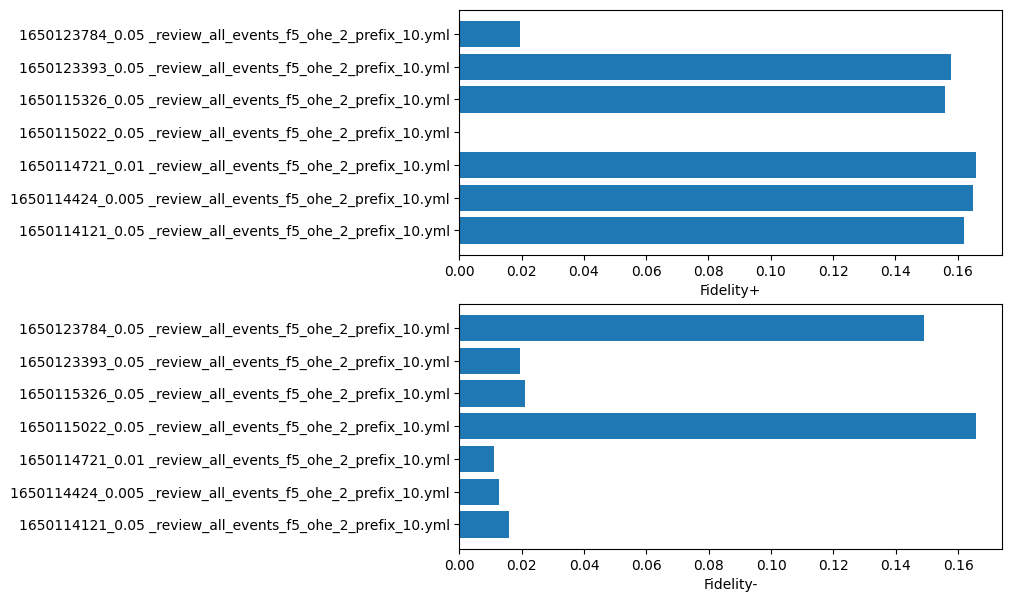

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

####Länge 13

In [ ]:
# Dataset und Model
key = 13
dataset13 = dataset[key]
input_dim = dataset13[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset13)

In [ ]:
print(path)

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 6598/6598 [00:42<00:00, 155.72it/s]


Epoch: 0 | Loss: 4325.954895913601


100%|██████████| 6598/6598 [00:42<00:00, 155.21it/s]


Epoch: 1 | Loss: 4276.408523142338


100%|██████████| 6598/6598 [00:41<00:00, 157.50it/s]


Epoch: 2 | Loss: 4233.738000005484


100%|██████████| 6598/6598 [00:42<00:00, 156.52it/s]


Epoch: 3 | Loss: 4229.486706197262


100%|██████████| 6598/6598 [00:42<00:00, 156.99it/s]


Epoch: 4 | Loss: 4173.628170847893
PGExplainer Anwenden


100%|██████████| 1650/1650 [00:22<00:00, 73.00it/s]


Fidelity+: 0.17337366938591003, Fidelity-: 0.01241771038621664, Sparsity: 0.4643355906009674
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 6598/6598 [00:42<00:00, 155.71it/s]


Epoch: 0 | Loss: 4325.769288182259


100%|██████████| 6598/6598 [00:42<00:00, 155.43it/s]


Epoch: 1 | Loss: 4319.502963423729


100%|██████████| 6598/6598 [00:42<00:00, 154.84it/s]


Epoch: 2 | Loss: 4309.303906142712


100%|██████████| 6598/6598 [00:42<00:00, 155.71it/s]


Epoch: 3 | Loss: 4299.213239133358


100%|██████████| 6598/6598 [00:42<00:00, 155.98it/s]


Epoch: 4 | Loss: 4278.954664856195
PGExplainer Anwenden


100%|██████████| 1650/1650 [00:22<00:00, 72.17it/s]


Fidelity+: 0.17551760375499725, Fidelity-: 0.009479425847530365, Sparsity: 0.4647085964679718
save Hyperparameter


In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.01--------------------------


100%|██████████| 6598/6598 [00:42<00:00, 156.68it/s]


Epoch: 0 | Loss: 4326.884096115828


100%|██████████| 6598/6598 [00:42<00:00, 156.09it/s]


Epoch: 1 | Loss: 4317.428013145924


100%|██████████| 6598/6598 [00:42<00:00, 154.56it/s]


Epoch: 2 | Loss: 4302.857370972633


100%|██████████| 6598/6598 [00:43<00:00, 152.21it/s]


Epoch: 3 | Loss: 4283.144427835941


100%|██████████| 6598/6598 [00:43<00:00, 152.96it/s]


Epoch: 4 | Loss: 4253.938513457775
PGExplainer Anwenden


100%|██████████| 1650/1650 [00:23<00:00, 70.33it/s]


Fidelity+: 0.17488910257816315, Fidelity-: 0.009916900657117367, Sparsity: 0.46419572830200195
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 6598/6598 [00:44<00:00, 149.90it/s]


Epoch: 0 | Loss: 3968.5012092888355


100%|██████████| 6598/6598 [00:42<00:00, 154.75it/s]


Epoch: 1 | Loss: 3775.062442213297


100%|██████████| 6598/6598 [00:42<00:00, 155.42it/s]


Epoch: 2 | Loss: 3616.698332577944


100%|██████████| 6598/6598 [00:42<00:00, 156.17it/s]


Epoch: 3 | Loss: 3603.0521055758


100%|██████████| 6598/6598 [00:42<00:00, 154.00it/s]


Epoch: 4 | Loss: 3602.7995313107967
PGExplainer Anwenden


100%|██████████| 1650/1650 [00:23<00:00, 71.37it/s]


Fidelity+: 2.52868198602485e-10, Fidelity-: 0.17655722796916962, Sparsity: 1.0
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 6598/6598 [00:42<00:00, 155.78it/s]


Epoch: 0 | Loss: 4322.18486225605


100%|██████████| 6598/6598 [00:42<00:00, 154.31it/s]


Epoch: 1 | Loss: 4275.005523920059


100%|██████████| 6598/6598 [00:42<00:00, 154.88it/s]


Epoch: 2 | Loss: 4233.54750546813


100%|██████████| 6598/6598 [00:42<00:00, 154.24it/s]


Epoch: 3 | Loss: 4233.689959079027


100%|██████████| 6598/6598 [00:42<00:00, 154.77it/s]


Epoch: 4 | Loss: 4172.025295466185
PGExplainer Anwenden


100%|██████████| 1650/1650 [00:23<00:00, 69.36it/s]


Fidelity+: 0.1744915395975113, Fidelity-: 0.011197368614375591, Sparsity: 0.46428894996643066
save Hyperparameter


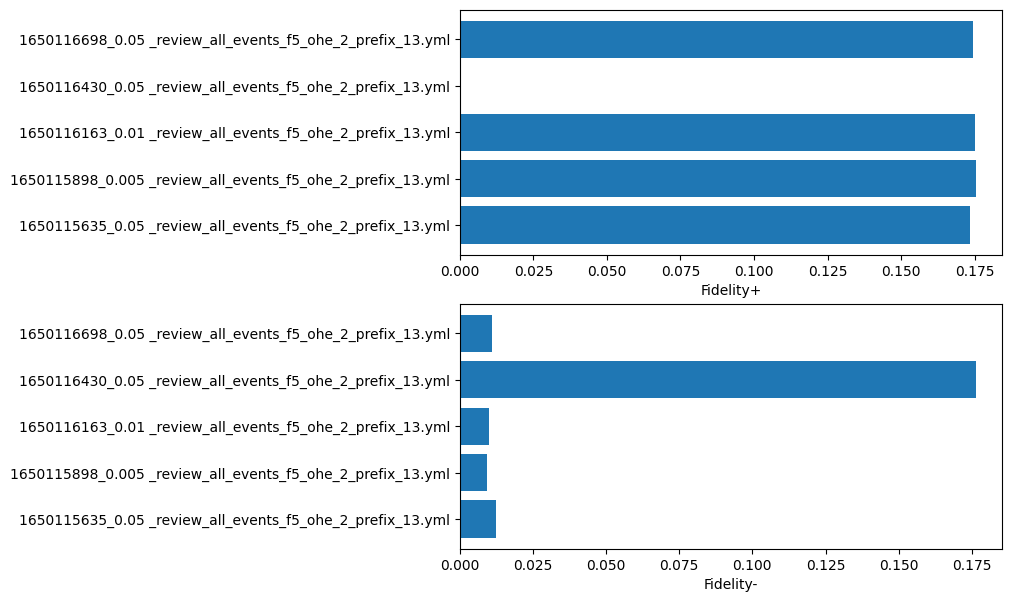

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

####Länge 16

In [ ]:
# Dataset und Model
key = 16
dataset16 = dataset[key]
input_dim = dataset16[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset16)

In [ ]:
print(path)

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5433/5433 [00:35<00:00, 154.03it/s]


Epoch: 0 | Loss: 3669.492305994034


100%|██████████| 5433/5433 [00:35<00:00, 155.08it/s]


Epoch: 1 | Loss: 3657.2875348329544


100%|██████████| 5433/5433 [00:34<00:00, 155.35it/s]


Epoch: 2 | Loss: 3578.463814675808


100%|██████████| 5433/5433 [00:35<00:00, 154.69it/s]


Epoch: 3 | Loss: 3492.0340009331703


100%|██████████| 5433/5433 [00:34<00:00, 155.47it/s]


Epoch: 4 | Loss: 3409.881339251995
PGExplainer Anwenden


100%|██████████| 1359/1359 [00:18<00:00, 71.87it/s]


Fidelity+: 0.10752639919519424, Fidelity-: 0.07473193854093552, Sparsity: 0.49135392904281616
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 5433/5433 [00:35<00:00, 154.52it/s]


Epoch: 0 | Loss: 3671.312779992819


100%|██████████| 5433/5433 [00:35<00:00, 152.88it/s]


Epoch: 1 | Loss: 3666.487069129944


100%|██████████| 5433/5433 [00:35<00:00, 154.72it/s]


Epoch: 2 | Loss: 3658.483084052801


100%|██████████| 5433/5433 [00:34<00:00, 155.83it/s]


Epoch: 3 | Loss: 3654.2579244077206


100%|██████████| 5433/5433 [00:34<00:00, 157.24it/s]


Epoch: 4 | Loss: 3638.379762619734
PGExplainer Anwenden


100%|██████████| 1359/1359 [00:18<00:00, 72.46it/s]


Fidelity+: 0.15228377282619476, Fidelity-: 0.019199006259441376, Sparsity: 0.4494113326072693
save Hyperparameter


In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.01--------------------------


100%|██████████| 5433/5433 [00:35<00:00, 154.72it/s]


Epoch: 0 | Loss: 3667.2426049411297


100%|██████████| 5433/5433 [00:35<00:00, 154.59it/s]


Epoch: 1 | Loss: 3660.171555429697


100%|██████████| 5433/5433 [00:34<00:00, 156.22it/s]


Epoch: 2 | Loss: 3649.440468966961


100%|██████████| 5433/5433 [00:35<00:00, 154.70it/s]


Epoch: 3 | Loss: 3621.9138426184654


100%|██████████| 5433/5433 [00:34<00:00, 155.68it/s]


Epoch: 4 | Loss: 3594.4562051296234
PGExplainer Anwenden


100%|██████████| 1359/1359 [00:18<00:00, 71.74it/s]


Fidelity+: 0.16580763459205627, Fidelity-: 0.004339770879596472, Sparsity: 0.4556659162044525
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5433/5433 [00:34<00:00, 155.67it/s]


Epoch: 0 | Loss: 3298.7730081379414


100%|██████████| 5433/5433 [00:34<00:00, 155.56it/s]


Epoch: 1 | Loss: 3147.5435649454594


100%|██████████| 5433/5433 [00:34<00:00, 155.74it/s]


Epoch: 2 | Loss: 3044.3856848180294


100%|██████████| 5433/5433 [00:35<00:00, 154.88it/s]


Epoch: 3 | Loss: 3041.1322260200977


100%|██████████| 5433/5433 [00:34<00:00, 156.22it/s]


Epoch: 4 | Loss: 3041.1430225372314
PGExplainer Anwenden


100%|██████████| 1359/1359 [00:18<00:00, 72.42it/s]


Fidelity+: 8.893416634236928e-06, Fidelity-: 0.15935145318508148, Sparsity: 0.9992641806602478
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 5433/5433 [00:34<00:00, 156.05it/s]


Epoch: 0 | Loss: 3668.0369011461735


100%|██████████| 5433/5433 [00:34<00:00, 155.81it/s]


Epoch: 1 | Loss: 3661.5996747910976


100%|██████████| 5433/5433 [00:34<00:00, 156.05it/s]


Epoch: 2 | Loss: 3597.8965513706207


100%|██████████| 5433/5433 [00:34<00:00, 156.57it/s]


Epoch: 3 | Loss: 3494.3555295467377


100%|██████████| 5433/5433 [00:34<00:00, 156.66it/s]


Epoch: 4 | Loss: 3400.712397545576
PGExplainer Anwenden


100%|██████████| 1359/1359 [00:19<00:00, 69.39it/s]


Fidelity+: 0.10904745757579803, Fidelity-: 0.07202011346817017, Sparsity: 0.4907100796699524
save Hyperparameter


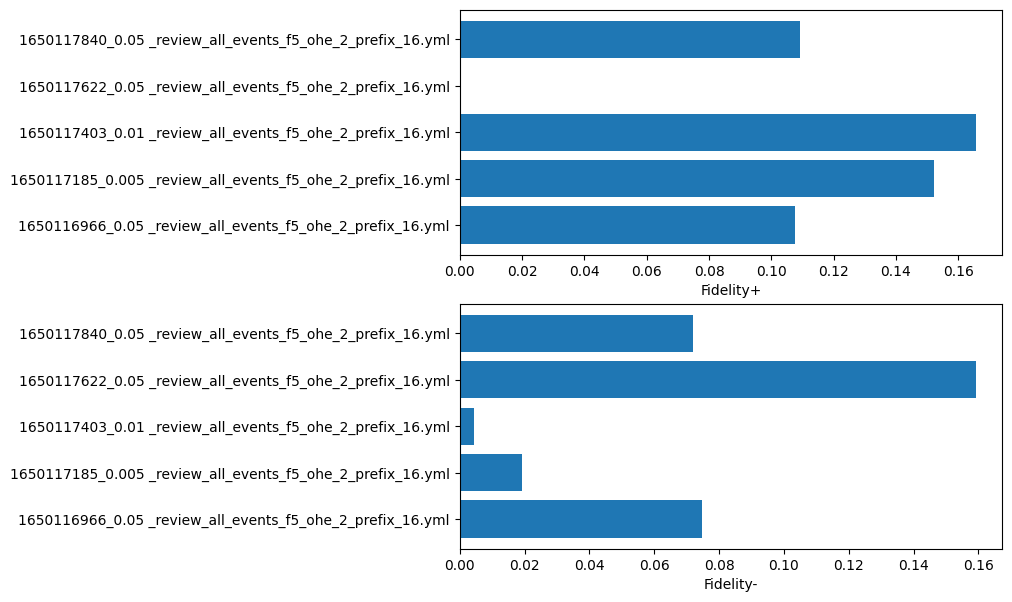

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

####Länge 19

In [ ]:
# Dataset und Model
key = 19
dataset19 = dataset[key]
input_dim = dataset19[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset19)

In [ ]:
print(path)

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 4256/4256 [00:27<00:00, 155.54it/s]


Epoch: 0 | Loss: 2953.923569470644


100%|██████████| 4256/4256 [00:27<00:00, 155.59it/s]


Epoch: 1 | Loss: 2923.8031310737133


100%|██████████| 4256/4256 [00:27<00:00, 154.17it/s]


Epoch: 2 | Loss: 2832.346103578806


100%|██████████| 4256/4256 [00:27<00:00, 156.18it/s]


Epoch: 3 | Loss: 2733.1399086415768


100%|██████████| 4256/4256 [00:27<00:00, 155.10it/s]


Epoch: 4 | Loss: 2671.918896704912
PGExplainer Anwenden


100%|██████████| 1064/1064 [00:14<00:00, 72.04it/s]


Fidelity+: 0.12820985913276672, Fidelity-: 0.04580437019467354, Sparsity: 0.5257716774940491
save Hyperparameter


In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.005--------------------------


100%|██████████| 4256/4256 [00:27<00:00, 155.57it/s]


Epoch: 0 | Loss: 2949.550278931856


100%|██████████| 4256/4256 [00:27<00:00, 155.11it/s]


Epoch: 1 | Loss: 2943.77994915843


100%|██████████| 4256/4256 [00:27<00:00, 154.77it/s]


Epoch: 2 | Loss: 2938.333615452051


100%|██████████| 4256/4256 [00:28<00:00, 151.04it/s]


Epoch: 3 | Loss: 2927.3137600123882


100%|██████████| 4256/4256 [00:28<00:00, 147.46it/s]


Epoch: 4 | Loss: 2903.5665486454964
PGExplainer Anwenden


100%|██████████| 1064/1064 [00:15<00:00, 70.56it/s]


Fidelity+: 0.14180171489715576, Fidelity-: 0.025507861748337746, Sparsity: 0.5057380795478821
save Hyperparameter


In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.01--------------------------


100%|██████████| 4256/4256 [00:28<00:00, 149.80it/s]


Epoch: 0 | Loss: 2949.8459207713604


100%|██████████| 4256/4256 [00:27<00:00, 153.06it/s]


Epoch: 1 | Loss: 2943.282213628292


100%|██████████| 4256/4256 [00:27<00:00, 154.29it/s]


Epoch: 2 | Loss: 2927.6802691221237


100%|██████████| 4256/4256 [00:27<00:00, 154.93it/s]


Epoch: 3 | Loss: 2901.693211466074


100%|██████████| 4256/4256 [00:27<00:00, 154.67it/s]


Epoch: 4 | Loss: 2862.421926498413
PGExplainer Anwenden


100%|██████████| 1064/1064 [00:14<00:00, 71.70it/s]


Fidelity+: 0.1356709748506546, Fidelity-: 0.03719550371170044, Sparsity: 0.519143283367157
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.001, 
    "coff_ent": 0.0005, 
    "t0": 7.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 4256/4256 [00:27<00:00, 153.57it/s]


Epoch: 0 | Loss: 2607.7724422216415


100%|██████████| 4256/4256 [00:28<00:00, 150.93it/s]


Epoch: 1 | Loss: 2509.2692432403564


100%|██████████| 4256/4256 [00:27<00:00, 154.16it/s]


Epoch: 2 | Loss: 2406.9509313702583


100%|██████████| 4256/4256 [00:27<00:00, 154.11it/s]


Epoch: 3 | Loss: 2404.2115456461906


100%|██████████| 4256/4256 [00:27<00:00, 153.27it/s]


Epoch: 4 | Loss: 2404.5755876898766
PGExplainer Anwenden


100%|██████████| 1064/1064 [00:14<00:00, 71.38it/s]


Fidelity+: 0.00021971068053971976, Fidelity-: 0.15210026502609253, Sparsity: 0.9988129138946533
save Hyperparameter


In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.6,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 10.0,
    "t1": 1.0,
    "epochs": 5
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
result_col = run_tuning(param, model, ds_train, ds_test, f"{dataset_name}_{key}" , device, path, hidden_channel)


---------------Learning-Rate: 0.05--------------------------


100%|██████████| 4256/4256 [00:28<00:00, 151.46it/s]


Epoch: 0 | Loss: 2951.4718621373177


100%|██████████| 4256/4256 [00:28<00:00, 150.95it/s]


Epoch: 1 | Loss: 2931.508586615324


100%|██████████| 4256/4256 [00:28<00:00, 151.02it/s]


Epoch: 2 | Loss: 2841.119732826948


100%|██████████| 4256/4256 [00:28<00:00, 150.88it/s]


Epoch: 3 | Loss: 2725.1881870925426


100%|██████████| 4256/4256 [00:28<00:00, 151.27it/s]


Epoch: 4 | Loss: 2666.467108696699
PGExplainer Anwenden


100%|██████████| 1064/1064 [00:15<00:00, 69.24it/s]


Fidelity+: 0.12741084396839142, Fidelity-: 0.04839480668306351, Sparsity: 0.5254749655723572
save Hyperparameter


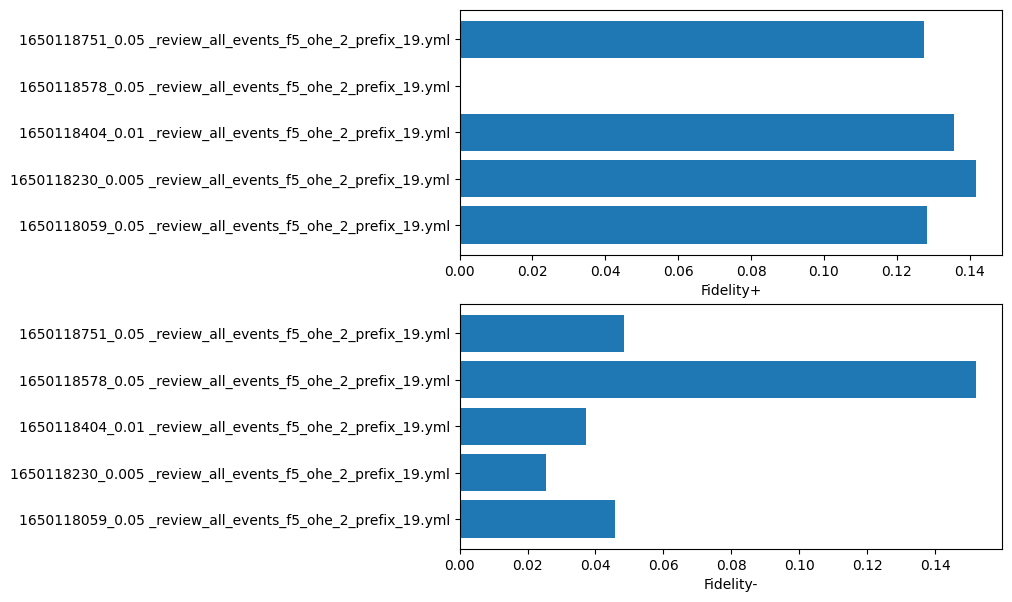

In [ ]:
visual_tuning_results(f"{dataset_name}_{key}", path)

##Trainieren

###Aktivitäten basiert

In [ ]:
dataset_name


'review_sn_f3_ohe_2'

In [ ]:
model = load_gcn(dataset_name, input_dim, device, path)

In [ ]:
param = {
    "lr": 0.05,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20}
  

In [ ]:
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = "pgexplainer_" + dataset_name

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer / pgexplainer_training_name))
save_hyperparam_results(param, path_pgexplainer / f"{pgexplainer_training_name}.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 8000/8000 [01:16<00:00, 104.74it/s]


Epoch: 0 | Loss: 1560.9820981658995


100%|██████████| 8000/8000 [01:16<00:00, 104.61it/s]


Epoch: 1 | Loss: 1003.4259928506799


100%|██████████| 8000/8000 [01:16<00:00, 104.30it/s]


Epoch: 2 | Loss: 900.8782941807294


100%|██████████| 8000/8000 [01:16<00:00, 104.30it/s]


Epoch: 3 | Loss: 874.1263203812414


100%|██████████| 8000/8000 [01:16<00:00, 104.00it/s]


Epoch: 4 | Loss: 846.8065419453778


100%|██████████| 8000/8000 [01:16<00:00, 104.39it/s]


Epoch: 5 | Loss: 858.4838549842243


100%|██████████| 8000/8000 [01:16<00:00, 104.76it/s]


Epoch: 6 | Loss: 854.7116420239909


100%|██████████| 8000/8000 [01:16<00:00, 104.78it/s]


Epoch: 7 | Loss: 839.8463621309493


100%|██████████| 8000/8000 [01:16<00:00, 104.74it/s]


Epoch: 8 | Loss: 854.8043965800898


100%|██████████| 8000/8000 [01:16<00:00, 105.03it/s]


Epoch: 9 | Loss: 861.844432383019


100%|██████████| 8000/8000 [01:15<00:00, 105.62it/s]


Epoch: 10 | Loss: 856.6964917476871


100%|██████████| 8000/8000 [01:15<00:00, 105.82it/s]


Epoch: 11 | Loss: 839.0305385495303


100%|██████████| 8000/8000 [01:15<00:00, 105.61it/s]


Epoch: 12 | Loss: 841.3835279904306


100%|██████████| 8000/8000 [01:15<00:00, 106.21it/s]


Epoch: 13 | Loss: 845.7217238210142


100%|██████████| 8000/8000 [01:15<00:00, 106.13it/s]


Epoch: 14 | Loss: 848.4821461196989


100%|██████████| 8000/8000 [01:15<00:00, 106.08it/s]


Epoch: 15 | Loss: 848.6197273663711


100%|██████████| 8000/8000 [01:16<00:00, 104.89it/s]


Epoch: 16 | Loss: 849.8216159290168


100%|██████████| 8000/8000 [01:15<00:00, 105.67it/s]


Epoch: 17 | Loss: 847.1655882853083


100%|██████████| 8000/8000 [01:15<00:00, 105.64it/s]


Epoch: 18 | Loss: 843.3004001004156


100%|██████████| 8000/8000 [01:15<00:00, 105.70it/s]

Epoch: 19 | Loss: 837.4761128746904
save Hyperparameter
Saved: pgexplainer_review_sn_f3_ohe_2


###Event-basiert

####Ganzer Graph

In [ ]:
key = 0
dataset0 = dataset[key]
input_dim = dataset0[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset0)

In [ ]:
param = {
    "lr": 0.001,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
#pgexplainer_training_name = f"pgexplainer_{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ dataset_name / "pgexplainer"))
save_hyperparam_results(param, path_pgexplainer / f"{dataset_name}/param.yml")
print(f"Saved: {dataset_name}")

100%|██████████| 8000/8000 [00:50<00:00, 158.32it/s]


Epoch: 0 | Loss: 1613.2879517823458


100%|██████████| 8000/8000 [00:49<00:00, 162.62it/s]


Epoch: 1 | Loss: 1548.9898314587772


100%|██████████| 8000/8000 [00:51<00:00, 156.07it/s]


Epoch: 2 | Loss: 1545.8517448715866


100%|██████████| 8000/8000 [00:53<00:00, 150.56it/s]


Epoch: 3 | Loss: 1545.0543325990438


100%|██████████| 8000/8000 [00:49<00:00, 160.91it/s]


Epoch: 4 | Loss: 1569.849741525948


100%|██████████| 8000/8000 [00:49<00:00, 162.33it/s]


Epoch: 5 | Loss: 1534.9881242718548


100%|██████████| 8000/8000 [00:48<00:00, 164.17it/s]


Epoch: 6 | Loss: 1552.8799013476819


100%|██████████| 8000/8000 [00:48<00:00, 164.72it/s]


Epoch: 7 | Loss: 1567.5208692923188


100%|██████████| 8000/8000 [00:48<00:00, 164.58it/s]


Epoch: 8 | Loss: 1544.7288256846368


100%|██████████| 8000/8000 [00:48<00:00, 165.64it/s]


Epoch: 9 | Loss: 1559.5130657684058


100%|██████████| 8000/8000 [00:48<00:00, 165.52it/s]


Epoch: 10 | Loss: 1528.4289166107774


100%|██████████| 8000/8000 [00:48<00:00, 164.79it/s]


Epoch: 11 | Loss: 1524.6770885773003


100%|██████████| 8000/8000 [00:48<00:00, 164.55it/s]


Epoch: 12 | Loss: 1585.3965051081032


100%|██████████| 8000/8000 [00:49<00:00, 163.00it/s]


Epoch: 13 | Loss: 1543.6995749939233


100%|██████████| 8000/8000 [00:48<00:00, 165.28it/s]


Epoch: 14 | Loss: 1593.4981156531721


100%|██████████| 8000/8000 [00:48<00:00, 164.67it/s]


Epoch: 15 | Loss: 1585.3703643437475


100%|██████████| 8000/8000 [00:48<00:00, 163.33it/s]


Epoch: 16 | Loss: 1580.9991228515282


100%|██████████| 8000/8000 [00:48<00:00, 163.67it/s]


Epoch: 17 | Loss: 1568.9585142526776


100%|██████████| 8000/8000 [00:48<00:00, 163.75it/s]


Epoch: 18 | Loss: 1557.0891974093392


100%|██████████| 8000/8000 [00:49<00:00, 162.47it/s]


Epoch: 19 | Loss: 1463.010384012945
save Hyperparameter
Saved: review_all_events_f5_ohe_2_prefix


#### Länge 4

In [ ]:
key = 4
dataset4 = dataset[key]
input_dim = dataset4[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset4)

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 8000/8000 [00:48<00:00, 164.92it/s]


Epoch: 0 | Loss: 3457.432439774275


100%|██████████| 8000/8000 [00:48<00:00, 164.38it/s]


Epoch: 1 | Loss: 3455.1549406200647


100%|██████████| 8000/8000 [00:48<00:00, 163.87it/s]


Epoch: 2 | Loss: 3434.7814246304333


100%|██████████| 8000/8000 [00:48<00:00, 164.52it/s]


Epoch: 3 | Loss: 3410.7087441571057


100%|██████████| 8000/8000 [00:48<00:00, 164.43it/s]


Epoch: 4 | Loss: 3380.072227463126


100%|██████████| 8000/8000 [00:48<00:00, 163.53it/s]


Epoch: 5 | Loss: 3340.4293241538107


100%|██████████| 8000/8000 [00:48<00:00, 163.78it/s]


Epoch: 6 | Loss: 3277.8202749863267


100%|██████████| 8000/8000 [00:48<00:00, 164.25it/s]


Epoch: 7 | Loss: 3227.3954752758145


100%|██████████| 8000/8000 [00:48<00:00, 163.74it/s]


Epoch: 8 | Loss: 3195.4784186966717


100%|██████████| 8000/8000 [00:48<00:00, 163.81it/s]


Epoch: 9 | Loss: 3129.7207803092897


100%|██████████| 8000/8000 [00:48<00:00, 163.67it/s]


Epoch: 10 | Loss: 3099.6859641112387


100%|██████████| 8000/8000 [00:48<00:00, 163.79it/s]


Epoch: 11 | Loss: 3057.7036259137094


100%|██████████| 8000/8000 [00:48<00:00, 163.92it/s]


Epoch: 12 | Loss: 3033.462387356907


100%|██████████| 8000/8000 [00:48<00:00, 163.72it/s]


Epoch: 13 | Loss: 3001.4467346705496


100%|██████████| 8000/8000 [00:48<00:00, 163.44it/s]


Epoch: 14 | Loss: 2983.2603265196085


100%|██████████| 8000/8000 [00:48<00:00, 163.88it/s]


Epoch: 15 | Loss: 2956.9347803145647


100%|██████████| 8000/8000 [00:48<00:00, 163.84it/s]


Epoch: 16 | Loss: 2960.3530316390097


100%|██████████| 8000/8000 [00:49<00:00, 162.85it/s]


Epoch: 17 | Loss: 2956.7455610334873


100%|██████████| 8000/8000 [00:48<00:00, 164.03it/s]


Epoch: 18 | Loss: 2952.9521604385227


100%|██████████| 8000/8000 [00:48<00:00, 163.69it/s]


Epoch: 19 | Loss: 2922.1203359737992
save Hyperparameter
Saved: review_all_events_f5_ohe_2_prefix_4


#### Länge 7

In [ ]:
key = 7
dataset7 = dataset[key]
input_dim = dataset7[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset7)

In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 8000/8000 [00:48<00:00, 163.93it/s]


Epoch: 0 | Loss: 4795.6531402766705


100%|██████████| 8000/8000 [00:49<00:00, 162.62it/s]


Epoch: 1 | Loss: 4782.057232737541


100%|██████████| 8000/8000 [00:48<00:00, 163.81it/s]


Epoch: 2 | Loss: 4765.9705825001


100%|██████████| 8000/8000 [00:49<00:00, 163.00it/s]


Epoch: 3 | Loss: 4745.8314504772425


100%|██████████| 8000/8000 [00:48<00:00, 164.61it/s]


Epoch: 4 | Loss: 4723.668568342924


100%|██████████| 8000/8000 [00:48<00:00, 164.05it/s]


Epoch: 5 | Loss: 4696.891616240144


100%|██████████| 8000/8000 [00:49<00:00, 162.40it/s]


Epoch: 6 | Loss: 4665.757892623544


100%|██████████| 8000/8000 [00:49<00:00, 161.98it/s]


Epoch: 7 | Loss: 4632.2533014416695


100%|██████████| 8000/8000 [00:49<00:00, 161.65it/s]


Epoch: 8 | Loss: 4604.478542283177


100%|██████████| 8000/8000 [00:49<00:00, 161.34it/s]


Epoch: 9 | Loss: 4578.083346441388


100%|██████████| 8000/8000 [00:49<00:00, 161.23it/s]


Epoch: 10 | Loss: 4554.41389028728


100%|██████████| 8000/8000 [00:49<00:00, 161.70it/s]


Epoch: 11 | Loss: 4539.850201040506


100%|██████████| 8000/8000 [00:49<00:00, 161.16it/s]


Epoch: 12 | Loss: 4532.4202830046415


100%|██████████| 8000/8000 [00:49<00:00, 161.36it/s]


Epoch: 13 | Loss: 4528.323332190514


100%|██████████| 8000/8000 [00:49<00:00, 161.49it/s]


Epoch: 14 | Loss: 4527.620744660497


100%|██████████| 8000/8000 [00:49<00:00, 161.71it/s]


Epoch: 15 | Loss: 4528.592553973198


100%|██████████| 8000/8000 [00:49<00:00, 161.51it/s]


Epoch: 16 | Loss: 4532.943079918623


100%|██████████| 8000/8000 [00:49<00:00, 161.82it/s]


Epoch: 17 | Loss: 4534.712153971195


100%|██████████| 8000/8000 [00:49<00:00, 160.92it/s]


Epoch: 18 | Loss: 4536.6194220632315


100%|██████████| 8000/8000 [00:49<00:00, 161.63it/s]


Epoch: 19 | Loss: 4538.501411318779
save Hyperparameter
Saved: review_all_events_f5_ohe_2_prefix_7


####Länge 10

In [ ]:
key = 10
dataset10 = dataset[key]
input_dim = dataset10[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset10)

In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 7495/7495 [00:46<00:00, 160.84it/s]


Epoch: 0 | Loss: 4883.191755533218


100%|██████████| 7495/7495 [00:46<00:00, 160.88it/s]


Epoch: 1 | Loss: 4867.410222172737


100%|██████████| 7495/7495 [00:46<00:00, 160.82it/s]


Epoch: 2 | Loss: 4851.309612900019


100%|██████████| 7495/7495 [00:46<00:00, 161.86it/s]


Epoch: 3 | Loss: 4829.404909878969


100%|██████████| 7495/7495 [00:46<00:00, 160.84it/s]


Epoch: 4 | Loss: 4801.271572768688


100%|██████████| 7495/7495 [00:46<00:00, 161.36it/s]


Epoch: 5 | Loss: 4775.363092124462


100%|██████████| 7495/7495 [00:46<00:00, 160.88it/s]


Epoch: 6 | Loss: 4749.122926771641


100%|██████████| 7495/7495 [00:46<00:00, 160.55it/s]


Epoch: 7 | Loss: 4736.682405114174


100%|██████████| 7495/7495 [00:46<00:00, 161.45it/s]


Epoch: 8 | Loss: 4732.676060676575


100%|██████████| 7495/7495 [00:46<00:00, 161.29it/s]


Epoch: 9 | Loss: 4734.104459315538


100%|██████████| 7495/7495 [00:46<00:00, 161.35it/s]


Epoch: 10 | Loss: 4738.154134482145


100%|██████████| 7495/7495 [00:46<00:00, 162.12it/s]


Epoch: 11 | Loss: 4740.703305631876


100%|██████████| 7495/7495 [00:46<00:00, 161.53it/s]


Epoch: 12 | Loss: 4741.265937119722


100%|██████████| 7495/7495 [00:46<00:00, 161.39it/s]


Epoch: 13 | Loss: 4739.53134983778


100%|██████████| 7495/7495 [00:46<00:00, 160.73it/s]


Epoch: 14 | Loss: 4734.313658744097


100%|██████████| 7495/7495 [00:46<00:00, 161.52it/s]


Epoch: 15 | Loss: 4726.559876590967


100%|██████████| 7495/7495 [00:46<00:00, 160.44it/s]


Epoch: 16 | Loss: 4709.366715610027


100%|██████████| 7495/7495 [00:46<00:00, 161.89it/s]


Epoch: 17 | Loss: 4686.7042008936405


100%|██████████| 7495/7495 [00:46<00:00, 160.84it/s]


Epoch: 18 | Loss: 4651.423278540373


100%|██████████| 7495/7495 [00:46<00:00, 161.47it/s]


Epoch: 19 | Loss: 4612.118208795786
save Hyperparameter
Saved: review_all_events_f5_ohe_2_prefix_10


#### Länge 13

In [ ]:
key = 13
dataset13 = dataset[key]
input_dim = dataset13[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset13)

In [ ]:
param = {
    "lr": 0.05,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 6598/6598 [00:40<00:00, 161.63it/s]


Epoch: 0 | Loss: 4324.83702108264


100%|██████████| 6598/6598 [00:41<00:00, 160.63it/s]


Epoch: 1 | Loss: 4290.910281360149


100%|██████████| 6598/6598 [00:40<00:00, 161.61it/s]


Epoch: 2 | Loss: 4228.506661832333


100%|██████████| 6598/6598 [00:40<00:00, 160.99it/s]


Epoch: 3 | Loss: 4214.4667918384075


100%|██████████| 6598/6598 [00:40<00:00, 162.04it/s]


Epoch: 4 | Loss: 4189.166612744331


100%|██████████| 6598/6598 [00:40<00:00, 161.74it/s]


Epoch: 5 | Loss: 4127.780103236437


100%|██████████| 6598/6598 [00:40<00:00, 161.21it/s]


Epoch: 6 | Loss: 4048.9292719960213


100%|██████████| 6598/6598 [00:40<00:00, 161.37it/s]


Epoch: 7 | Loss: 4006.1639761328697


100%|██████████| 6598/6598 [00:40<00:00, 161.82it/s]


Epoch: 8 | Loss: 3968.632067590952


100%|██████████| 6598/6598 [00:41<00:00, 160.85it/s]


Epoch: 9 | Loss: 3911.922837495804


100%|██████████| 6598/6598 [00:40<00:00, 161.13it/s]


Epoch: 10 | Loss: 3879.9994136095047


100%|██████████| 6598/6598 [00:40<00:00, 162.28it/s]


Epoch: 11 | Loss: 3864.395401507616


100%|██████████| 6598/6598 [00:40<00:00, 161.55it/s]


Epoch: 12 | Loss: 3840.188625395298


100%|██████████| 6598/6598 [00:40<00:00, 161.30it/s]


Epoch: 13 | Loss: 3831.2203926444054


100%|██████████| 6598/6598 [00:40<00:00, 161.87it/s]


Epoch: 14 | Loss: 3831.1598557531834


100%|██████████| 6598/6598 [00:40<00:00, 161.93it/s]


Epoch: 15 | Loss: 3820.8491125404835


100%|██████████| 6598/6598 [00:41<00:00, 160.86it/s]


Epoch: 16 | Loss: 3818.363485753536


100%|██████████| 6598/6598 [00:41<00:00, 159.07it/s]


Epoch: 17 | Loss: 3819.457614660263


100%|██████████| 6598/6598 [00:41<00:00, 160.67it/s]


Epoch: 18 | Loss: 3818.4422917962074


100%|██████████| 6598/6598 [00:41<00:00, 160.87it/s]


Epoch: 19 | Loss: 3813.8983686566353
save Hyperparameter
Saved: review_all_events_f5_ohe_2_prefix_13


####Länge 16

In [ ]:
key = 16
dataset16 = dataset[key]
input_dim = dataset16[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset16)

In [ ]:
param = {
    "lr": 0.01,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 5433/5433 [00:33<00:00, 161.11it/s]


Epoch: 0 | Loss: 3667.3205667734146


100%|██████████| 5433/5433 [00:33<00:00, 162.10it/s]


Epoch: 1 | Loss: 3662.117706924677


100%|██████████| 5433/5433 [00:33<00:00, 161.80it/s]


Epoch: 2 | Loss: 3656.093507617712


100%|██████████| 5433/5433 [00:33<00:00, 161.39it/s]


Epoch: 3 | Loss: 3643.2388913035393


100%|██████████| 5433/5433 [00:33<00:00, 161.29it/s]


Epoch: 4 | Loss: 3629.848411977291


100%|██████████| 5433/5433 [00:33<00:00, 160.37it/s]


Epoch: 5 | Loss: 3612.5231988728046


100%|██████████| 5433/5433 [00:33<00:00, 160.90it/s]


Epoch: 6 | Loss: 3591.1528452038765


100%|██████████| 5433/5433 [00:34<00:00, 159.40it/s]


Epoch: 7 | Loss: 3567.9627391695976


100%|██████████| 5433/5433 [00:34<00:00, 158.67it/s]


Epoch: 8 | Loss: 3534.59053298831


100%|██████████| 5433/5433 [00:33<00:00, 160.68it/s]


Epoch: 9 | Loss: 3505.581485748291


100%|██████████| 5433/5433 [00:33<00:00, 162.18it/s]


Epoch: 10 | Loss: 3472.3491563498974


100%|██████████| 5433/5433 [00:33<00:00, 161.19it/s]


Epoch: 11 | Loss: 3441.6932007074356


100%|██████████| 5433/5433 [00:33<00:00, 161.52it/s]


Epoch: 12 | Loss: 3416.555211186409


100%|██████████| 5433/5433 [00:33<00:00, 161.22it/s]


Epoch: 13 | Loss: 3397.0695174634457


100%|██████████| 5433/5433 [00:33<00:00, 162.73it/s]


Epoch: 14 | Loss: 3381.3775133788586


100%|██████████| 5433/5433 [00:33<00:00, 161.91it/s]


Epoch: 15 | Loss: 3370.9155927300453


100%|██████████| 5433/5433 [00:33<00:00, 162.49it/s]


Epoch: 16 | Loss: 3363.3964434564114


100%|██████████| 5433/5433 [00:33<00:00, 161.96it/s]


Epoch: 17 | Loss: 3361.8813652694225


100%|██████████| 5433/5433 [00:33<00:00, 161.49it/s]


Epoch: 18 | Loss: 3358.085105776787


100%|██████████| 5433/5433 [00:33<00:00, 161.03it/s]


Epoch: 19 | Loss: 3356.416029781103
save Hyperparameter
Saved: review_all_events_f5_ohe_2_prefix_16


#### Länge 19

In [ ]:
key = 19
dataset19 = dataset[key]
input_dim = dataset19[0].x.shape[1]

# split
ds_train, ds_test = split_dataset_2_8(dataset19)

In [ ]:
param = {
    "lr": 0.005,
    "sparsity_ziel": 0.7,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20
}
model = load_gcn_key(dataset_name, key, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )

In [ ]:
# Name
pgexplainer_training_name = f"{dataset_name}_{key}"

# Explainer trainieren
explainer_pge.train_explanation_network(ds_train)

# Ergebnisse Speichern
torch.save(explainer_pge.state_dict(), str(path_pgexplainer/ pgexplainer_training_name/  "pgexplainer" ))
save_hyperparam_results(param, path_pgexplainer / pgexplainer_training_name / "param.yml")
print(f"Saved: {pgexplainer_training_name}")

100%|██████████| 4256/4256 [00:26<00:00, 162.91it/s]


Epoch: 0 | Loss: 2951.2253134846687


100%|██████████| 4256/4256 [00:26<00:00, 161.99it/s]


Epoch: 1 | Loss: 2949.904105246067


100%|██████████| 4256/4256 [00:26<00:00, 160.63it/s]


Epoch: 2 | Loss: 2945.2977611124516


100%|██████████| 4256/4256 [00:26<00:00, 162.47it/s]


Epoch: 3 | Loss: 2940.92504838109


100%|██████████| 4256/4256 [00:26<00:00, 159.61it/s]


Epoch: 4 | Loss: 2937.0080984830856


100%|██████████| 4256/4256 [00:26<00:00, 160.62it/s]


Epoch: 5 | Loss: 2928.554650604725


100%|██████████| 4256/4256 [00:26<00:00, 161.50it/s]


Epoch: 6 | Loss: 2923.716984421015


100%|██████████| 4256/4256 [00:26<00:00, 161.72it/s]


Epoch: 7 | Loss: 2913.6071482896805


100%|██████████| 4256/4256 [00:26<00:00, 160.73it/s]


Epoch: 8 | Loss: 2902.589061886072


100%|██████████| 4256/4256 [00:26<00:00, 161.14it/s]


Epoch: 9 | Loss: 2889.150211274624


100%|██████████| 4256/4256 [00:26<00:00, 161.95it/s]


Epoch: 10 | Loss: 2873.9041866362095


100%|██████████| 4256/4256 [00:26<00:00, 160.58it/s]


Epoch: 11 | Loss: 2854.228745609522


100%|██████████| 4256/4256 [00:26<00:00, 161.69it/s]


Epoch: 12 | Loss: 2832.22496470809


100%|██████████| 4256/4256 [00:26<00:00, 162.16it/s]


Epoch: 13 | Loss: 2817.552959829569


100%|██████████| 4256/4256 [00:26<00:00, 160.73it/s]


Epoch: 14 | Loss: 2799.0227006077766


100%|██████████| 4256/4256 [00:26<00:00, 159.16it/s]


Epoch: 15 | Loss: 2773.7028043866158


100%|██████████| 4256/4256 [00:26<00:00, 163.01it/s]


Epoch: 16 | Loss: 2753.359428346157


100%|██████████| 4256/4256 [00:26<00:00, 161.09it/s]


Epoch: 17 | Loss: 2732.1824448406696


100%|██████████| 4256/4256 [00:26<00:00, 163.23it/s]


Epoch: 18 | Loss: 2717.194840312004


100%|██████████| 4256/4256 [00:26<00:00, 162.13it/s]


Epoch: 19 | Loss: 2701.085761487484
save Hyperparameter
Saved: review_all_events_f5_ohe_2_prefix_19
